In [2]:
import sys
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from astropy.cosmology import WMAP9 as cosmology
from astropy.cosmology import z_at_value
import astropy.units as u
from KDEpy import FFTKDE  # Fastest 1D algorithm
import h5py as h5
import matplotlib.colors as mcolors

# Import COMPAS specific scripts
sys.path.append('/n/home04/aboesky/pgk/COMPAS/utils/CosmicIntegration')

# Import COMPAS root directory and set data
compasRootDir   = '/Users/adamboesky/Research/PRISE/COMPAS'

# Import COMPAS specific scripts
sys.path.append(compasRootDir + '/utils/CosmicIntegration/')

import ClassCOMPAS, ClassMSSFR, ClassCosmicIntegrator 

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_3776/588942005.py:28: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
path_to_data = '/Volumes/T7/Research_Data/final_alpha_CE_beta/'

In [4]:
alpha_vals = ['0.1', '0.5', '2.0', '10.0'] # All the alpha values
beta_vals = ['0.25', '0.5', '0.75'] # All the beta values

condensed_paths = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for alpha in alpha_vals:
    condensed_paths[alpha] = {}
    for beta in beta_vals:
        condensed_paths[alpha][beta] = path_to_data + 'output_alpha_CE_' + alpha + '_beta_' + beta + '/COMPAS_Output_Weighted.h5'

In [6]:
plt.style.use('ggplot')                                                          
# rainbow_cmap = matplotlib.cm.get_cmap('rainbow')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
num_colors = len(alpha_vals)
counter = 0
color_grid = {}
marker_grid = {}
linestyle_grid = {}
for alpha_index, alpha_val in enumerate(alpha_vals):
    color_grid[alpha_val] = {}
    marker_grid[alpha_val] = {}
    linestyle_grid[alpha_val] = {}
    for beta_index, beta_val in enumerate(beta_vals):
        # color_grid[alpha_val][beta_val] = rainbow_cmap(alpha_index/num_colors)
        if alpha_index == 0:
            color_grid[alpha_val][beta_val] = '#FF8456'
        elif alpha_index == 3:
            color_grid[alpha_val][beta_val] = colors[5]
        else:
            color_grid[alpha_val][beta_val] = colors[alpha_index]

        if beta_val == '0.25':
            linestyle_grid[alpha_val][beta_val] = 'solid'
            marker_grid[alpha_val][beta_val] = 'o'
        elif beta_val == '0.5':
            linestyle_grid[alpha_val][beta_val] = 'dashed'
            marker_grid[alpha_val][beta_val] = '^'
        elif beta_val == '0.75':
            linestyle_grid[alpha_val][beta_val] = 'dashdot'
            marker_grid[alpha_val][beta_val] = '*'

plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

In [7]:
def add_lookback_t_axes(ax, labelsize=15, z_range=[0, 10], no_label=False):
    ax2  = ax.twiny()
    # second x-axis for age
    # axes2.xaxis.labelpad = 20
    ax2.tick_params(labelsize=labelsize*0.9)
    redshifts = np.linspace(0,10,100)
    #strolger works in age not redshift
    ages      = cosmology.age(redshifts).value
    #find nearest redshift to age
    agelabels = np.array([1,2,3,4,5,7, 9]) # Gyr
    ageUniverse = cosmology.age(0)
    redshiftTicks = np.zeros(len(agelabels))
    for nr, age in enumerate(agelabels):
        distance = np.abs(ages-age)
        # distance = np.abs(ages-age+cosmology.age(np.array([10])).value[0])
        ind      = np.where(distance==np.min(distance))[0][0]
        redshiftTicks[nr] =  redshifts[ind]

    ax2.set_xlim(z_range)
    ax2.set_xticks(redshiftTicks)
    ax2.set_xticklabels(agelabels)
    if not no_label:
        nameX2 = r'\textbf{Age Universe [Gyr]}'
        ax2.set_xlabel(nameX2, fontsize=labelsize, labelpad=10)
    return ax2

# Rejection sample our assumed SFR

In [11]:
def SFR_Madau2(z):
    """
    https://arxiv.org/pdf/1606.07887.pdf
    """
    SFR = 0.01 * ((1+z)**2.6) / (1 + ((1+z)/3.2)**6.2) * 1e9 #[1e9 for GPc-3]
    return SFR # [Msun yr-1 Gpc-3] in comoving volume


fig = plt.figure(figsize=(10,7))

Ndraw=int(1E7)

z= np.linspace(0,10,Ndraw)

SFR = SFR_Madau2(z)




plt.scatter(z, SFR)

# plt.ylim(6, 8)
plt.yscale('log')
plt.show()



from scipy.stats import uniform

y_rej = uniform.rvs(10**6,10**9,size=Ndraw)

KeyboardInterrupt: 

In [24]:
mask_rej =  (SFR < y_rej)

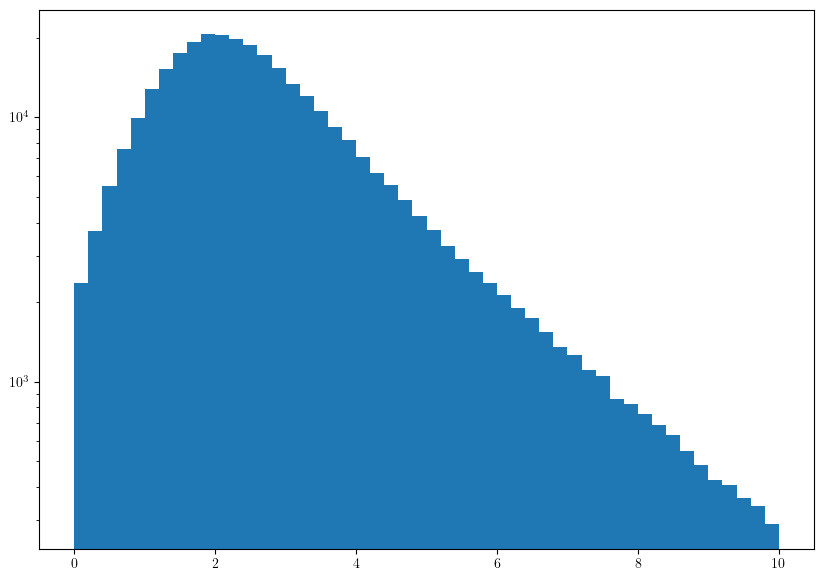

In [25]:
fig = plt.figure(figsize=(10,7))

sfr_sample = z[~mask_rej]
plt.hist(sfr_sample, 50)
plt.yscale('log')
plt.show()

In [29]:
ages_yrs = cosmology.age(z[~mask_rej]).to(u.Myr).value

ages_yrs_10 = ages_yrs * u.Myr + 10 * u.Myr
z_shifted_10 = z_at_value(cosmology.age, ages_yrs_10, zmin=-1)

ages_yrs_20 = ages_yrs * u.Myr + 20 * u.Myr
z_shifted_20 = z_at_value(cosmology.age, ages_yrs_20, zmin=-1)

ages_yrs_100 = ages_yrs * u.Myr + 100 * u.Myr
z_shifted_100 = z_at_value(cosmology.age, ages_yrs_100, zmin=-1)

ages_yrs_500 = ages_yrs * u.Myr + 0.5 * u.Gyr
z_shifted_500 = z_at_value(cosmology.age, ages_yrs_500, zmin=-1)

ages_yrs_750 = ages_yrs * u.Myr + 0.75 * u.Gyr
z_shifted_750 = z_at_value(cosmology.age, ages_yrs_750, zmin=-1)

ages_yrs_1000 = ages_yrs * u.Myr + 1 * u.Gyr
z_shifted_1000 = z_at_value(cosmology.age, ages_yrs_1000, zmin=-1)

/Users/adamboesky/opt/anaconda3/envs/PRISE/lib/python3.9/site-packages/astropy/cosmology/flrw/base.py:1057: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(self._lookback_time_integrand_scalar, z, inf)[0]


KeyboardInterrupt: 

In [30]:
ages_yrs_1000 = ages_yrs * u.Myr + 1 * u.Gyr
z_shifted_1000 = z_at_value(cosmology.age, ages_yrs_1000, zmin=-1)

In [31]:
axis = np.arange(-1, 10.1, 0.1)
scale_factor = len(z_shifted_10)

kde = FFTKDE(bw=0.2).fit(z[~mask_rej]).evaluate(axis)

kde_10 = FFTKDE(bw=0.2).fit(z_shifted_10).evaluate(axis)
kde_20 = FFTKDE(bw=0.2).fit(z_shifted_20).evaluate(axis)
kde_100 = FFTKDE(bw=0.2).fit(z_shifted_100).evaluate(axis)
kde_500 = FFTKDE(bw=0.2).fit(z_shifted_500).evaluate(axis)
kde_750 = FFTKDE(bw=0.2).fit(z_shifted_750).evaluate(axis)
kde_1000 = FFTKDE(bw=0.2).fit(z_shifted_1000).evaluate(axis)

In [32]:
uniform_delayed_sfrs = {'axis': axis, '0': kde, '10': kde_10, '20': kde_20, '100': kde_100, '500': kde_500, '750': kde_750, '1000': kde_1000}
with open("uniform_delay_sfr.pkl", "wb") as f:
    pickle.dump(uniform_delayed_sfrs, f)

In [8]:
with open('uniform_delay_sfr.pkl', 'rb') as f:
    uniform_delayed_sfrs = pickle.load(f)

# Plot SFR Delayed by constant value

In [9]:
def t_at_z(z):
    return cosmology.age(z).to(u.Myr).value

def z_at_t(t):
    return z_at_value(cosmology.age, t * u.Myr, zmin=-1)

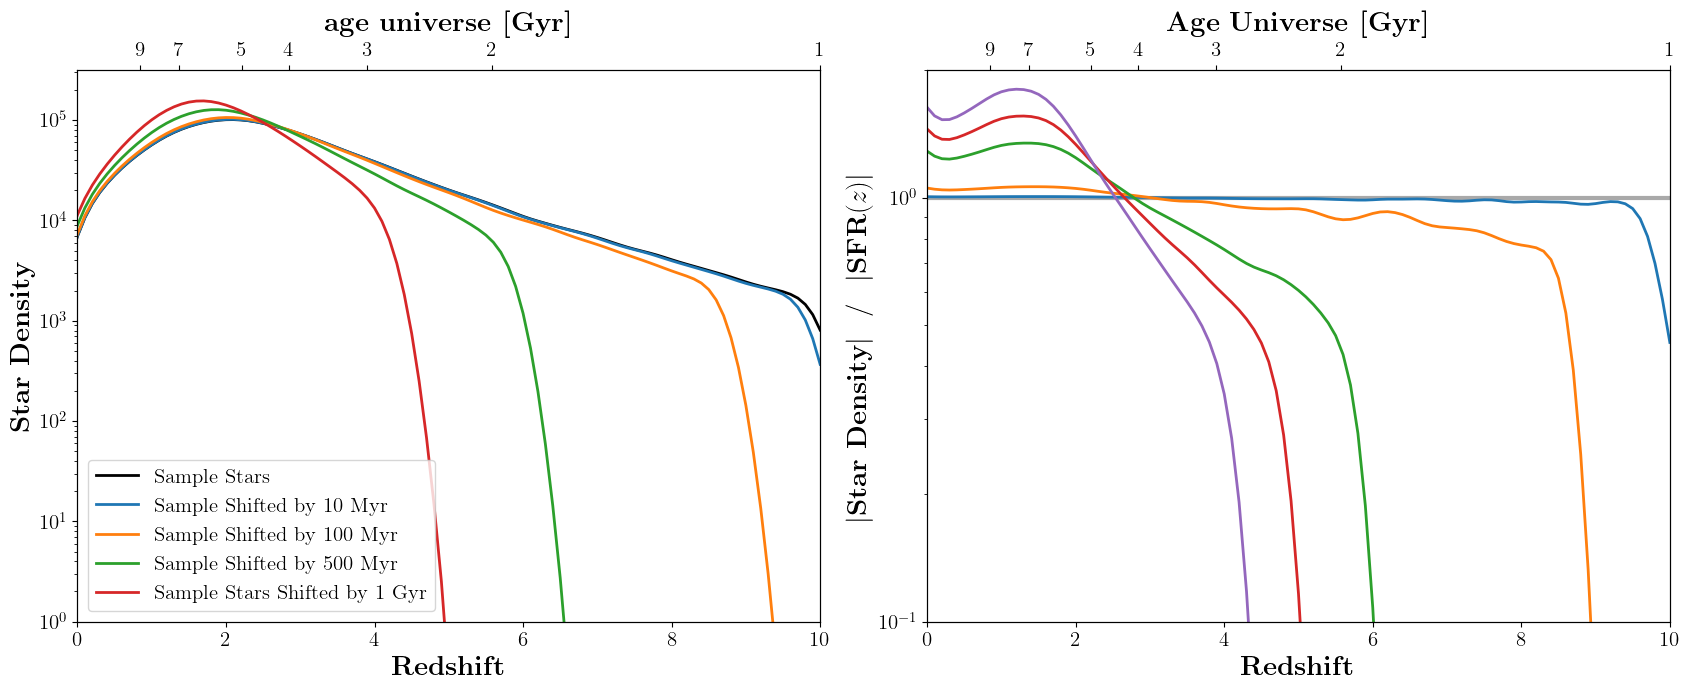

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(17,7))
lw=2

# Top plot
ax[0].plot(axis, kde * scale_factor, color='k', lw=lw, label='Sample Stars')
ax[0].plot(axis, kde_10 * scale_factor, lw=lw, label='Sample Shifted by 10 Myr')
ax[0].plot(axis, kde_100 * scale_factor, lw=lw, label='Sample Shifted by 100 Myr')
ax[0].plot(axis, kde_500 * scale_factor, lw=lw, label='Sample Shifted by 500 Myr')
ax[0].plot(axis, kde_1000 * scale_factor, lw=lw, label='Sample Stars Shifted by 1 Gyr')
ax[0].set_yscale('log')
ax[0].set_ylim([1, 10E5 / 10**0.5])
ax[0].set_xlim([0,10])
ax[0].legend(fontsize=15, loc='lower left')
ax[0].set_xlabel(r'\textbf{Redshift}', fontsize=20)
ax[0].set_ylabel(r'\textbf{Star Density}', fontsize=20)
ax[0].tick_params(axis='both', labelsize=15)

ax2  = ax[0].twiny()
# second x-axis for age
# axes2.xaxis.labelpad = 20
ax2.tick_params(labelsize=15)
redshifts = np.linspace(0,6,100)
#strolger works in age not redshift
ages      = cosmology.age(redshifts).value
#find nearest redshift to age
agelabels = np.array([1,2,3,4,5,7, 9]) #Gyr
ageUniverse = cosmology.age(0)
redshiftTicks = np.zeros(len(agelabels))
for nr, age in enumerate(agelabels):
    distance = np.abs(ages-age)
    ind      = np.where(distance==np.min(distance))[0][0]
    redshiftTicks[nr] =  redshifts[ind]

ax2.set_xticks(redshiftTicks)
ax2.set_xticklabels(agelabels)
nameX2 = r'\textbf{age universe [Gyr]}'
ax2.set_xlabel(nameX2, fontsize=20, labelpad=8)

# Bottom plot
SFR = SFR_Madau2(axis)
sfr_area = np.trapz(SFR, x=axis)               # Get the area under the curve
SFR_norm = SFR/sfr_area
# ax[1].plot(axis, kde/SFR_norm, lw=lw, color='k', label='Sample Stars')
ax[1].plot(axis, kde_10/kde, lw=lw, label='Sample Shifted by 10 Myr')
ax[1].plot(axis, kde_100/kde, lw=lw, label='Sample Shifted by 100 Myr')
ax[1].plot(axis, kde_500/kde, lw=lw, label='Sample Shifted by 500 Myr')
ax[1].plot(axis, kde_750/kde, lw=lw, label='Sample Shifted by 750 Myr')
ax[1].plot(axis, kde_1000/kde, lw=lw, label='Sample Shifted by 1 Gyr')
ax[1].set_yscale('log')
ax[1].set_ylim([10**-1, 2])
ax[1].set_xlim([0,10])
ax[1].set_xlabel(r'\textbf{Redshift}', fontsize=20)
ax[1].set_ylabel(r'\textbf{$|\textrm{Star Density}|  \ \  /  \ \  |\textrm{SFR}(z)|$}', fontsize=20)
ax[1].tick_params(axis='both', labelsize=15)
# Plot horizontal line for SFR on the normalized plots
ax[1].axhline(y=1, color='darkgray', lw=3, zorder=-1)

ax2  = ax[1].twiny()
# second x-axis for age
# axes2.xaxis.labelpad = 20
ax2.tick_params(labelsize=15)
redshifts = np.linspace(0,6,100)
#strolger works in age not redshift
ages      = cosmology.age(redshifts).value
#find nearest redshift to age
agelabels = np.array([1,2,3,4,5,7, 9]) #Gyr
ageUniverse = cosmology.age(0)
redshiftTicks = np.zeros(len(agelabels))
for nr, age in enumerate(agelabels):
    distance = np.abs(ages-age)
    ind      = np.where(distance==np.min(distance))[0][0]
    redshiftTicks[nr] =  redshifts[ind]

ax2.set_xticks(redshiftTicks)
ax2.set_xticklabels(agelabels)
nameX2 = r'\textbf{Age Universe [Gyr]}'
ax2.set_xlabel(nameX2, fontsize=20, labelpad=8)
fig.tight_layout()

# Plot our $t_\textrm{delay}$ distribution

In [10]:
# First define the parameters

# For what DCO would you like the rate?  options: all, BBH, BHNS BNS
weight_column   = 'mixture_weight'
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 1.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 * (1 + max_redshift_detection)
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5 * u.Msun 
m1_max          = 150 * u.Msun
m2_min          = m1_min * 0.01 # m2_min = min(q) * min(m1)
fbin            = 1.0

rainbow_cmap = matplotlib.cm.get_cmap('rainbow')
num_colors = len(alpha_vals)*len(beta_vals)
counter = 0
color_grid = {}
for alphva_index, alpha_val in enumerate(alpha_vals):
    color_grid[alpha_val] = {}
    for beta_index, beta_val in enumerate(beta_vals):
        color_grid[alpha_val][beta_val] = rainbow_cmap(counter/num_colors)
        counter+=1

# Van Son 2022 prescriptions:
mu0             = 0.025
muz             = -0.048
sigma0          = 1.125
sigmaz          = 0.048
alpha           = -1.77

aSF             = 0.02
bSF             = 1.48 
cSF             = 4.45 
dSF             = 5.9

# MY FIDUCIAL MSSFR PRESCRIPTIONS
lognormal=False                                     # !!! IF THIS PARAMETER IS FALSE, IT WILL USE THE NON-LOGNORMAL MSSFR PRESCRIPTIONS !!!
Zprescription='MZ_GSMF'
SFRprescription='Madau et al. (2017)'
GSMFprescription='Panter et al. (2004) Single'
ZMprescription='Ma et al. (2016)'
logNormalPrescription=None

In [103]:
def plot_delay_time_distribution(condensed_paths, alpha_val, beta_val, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # The desired redshifts
    redshifts = ['0.2', '2.0', '6.0']
    
    folder_path = path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val
    
    # Dictionary to put all the weights in
    merger_weights = {}

    with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_weights_at_redshifts.h5', 'rb') as f:

        for desired_z in redshifts:
            # Get data
            h5_data = h5.File(f)
            merger_weights[desired_z] = h5_data['redshift_' + desired_z]['total_formation_rates'][...]
    
    # start by getting the necessary data from the COMPAS file
    COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
    COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
    COMPAS.setCOMPASData()
    COMPAS.set_sw_weights(weight_column)
    
    # Mak masks to filer for the channel only
    time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
    t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
        

    ####### Plot
    fig = plt.figure(figsize=(10,7))
    
    # Iterate through redshift values and plot delay time distributions
    for desired_z in redshifts:
        # axis = np.linspace(0, max(t_delay)+10, num=1000)
        # kde = FFTKDE(bw=100).fit(t_delay, weights=merger_weights[desired_z]).evaluate(axis)
        # plt.plot(axis, kde, label='z = ' + desired_z)

        # plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0.5, 3.2, 25), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
        #        alpha=1, lw=1.5)
        
        plt.hist(t_delay, weights=merger_weights[desired_z], bins=np.linspace(0, 15000, 50), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
            alpha=1, lw=1.5)




        # if desired_z == '2.0':
        #     plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0, 1400, 25), label='z = ' + desired_z, zorder=-1, density=True, histtype='step', facecolor='g',
        #        alpha=1, lw=1.5)
        # else:
            # plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0, 1400, 25), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
            #    alpha=1, lw=1.5)
            
    
    # Format
    plt.legend(fontsize=15)
    plt.xlabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
    plt.ylabel(r'\textbf{Density}', fontsize=20)
    plt.yscale('log')
    # plt.xscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

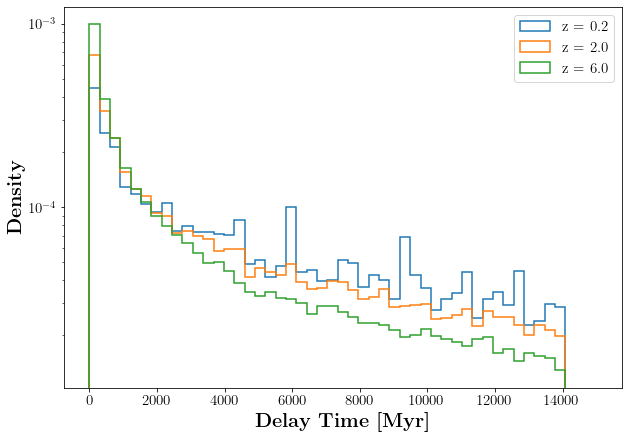

In [104]:
plot_delay_time_distribution(condensed_paths, '2.0', '0.5', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))                               

In [8]:
def plot_observable_delay_time_distribution(condensed_paths, alpha_val, beta_val, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # The desired redshifts
    redshifts = ['0.2', '2.0', '6.0']
    
    folder_path = path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val
    
    # Dictionary to put all the weights in
    merger_weights = {}

    with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_weights_at_redshifts.h5', 'rb') as f:

        for desired_z in redshifts:
            # Get data
            h5_data = h5.File(f)
            merger_weights[desired_z] = h5_data['redshift_' + desired_z]['total_formation_rates'][...]
    
    # start by getting the necessary data from the COMPAS file
    COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
    COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
    COMPAS.setCOMPASData()
    COMPAS.set_sw_weights(weight_column)
    
    # Mak masks to filer for the channel only
    time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
    t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
        

    ####### Plot
    fig = plt.figure(figsize=(10,7))
    color_labels = ['tab:blue', 'tab:orange', 'tab:green']
    heights = [10**0.32, 10**1.33, 10**0.58]
    bins = np.linspace(0, 15000, 50)
    
    # Iterate through redshift values and plot delay time distributions
    for index, desired_z in enumerate(redshifts):
        # axis = np.linspace(0, max(t_delay)+10, num=1000)
        # kde = FFTKDE(bw=100).fit(t_delay, weights=merger_weights[desired_z]).evaluate(axis)
        # plt.plot(axis, kde, label='z = ' + desired_z)

        # plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0.5, 3.2, 25), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
        #        alpha=1, lw=1.5)
        
        plt.hist(t_delay, weights=merger_weights[desired_z], bins=bins, label='z = ' + desired_z, density=False, histtype='step', facecolor='g',
            edgecolor = mcolors.TABLEAU_COLORS[color_labels[index]], alpha=1, lw=1.5)

        # Get the minimum delay time for mergers at the given redshift to be observable
        lookback_at_z_gyr = cosmology.lookback_time(float(desired_z))
        print('Minimum delay time for z =', desired_z, ':  ', lookback_at_z_gyr)
        # plt.plot(lookback_at_z_gyr*1000, heights[index], marker='*', markersize=18, color=mcolors.TABLEAU_COLORS[color_labels[index]])  # Plot a star at this value

        # Plot a grey box for the unobservable mergers
        min_edge = max(i for i in bins if i <= lookback_at_z_gyr/u.Myr)
        unobservable_mask = [t_delay >= min_edge]
        plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step', facecolor='0.85',
            edgecolor = 'lightgray', alpha=1, lw=1.5, zorder=-2, fill=True)
        plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step', facecolor='0.85',
            edgecolor = mcolors.TABLEAU_COLORS[color_labels[index]], alpha=1, lw=1.5, zorder=-1, hatch='/', fill=True)

        # if desired_z == '2.0':
        #     plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0, 1400, 25), label='z = ' + desired_z, zorder=-1, density=True, histtype='step', facecolor='g',
        #        alpha=1, lw=1.5)
        # else:
            # plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0, 1400, 25), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
            #    alpha=1, lw=1.5)
            
    
    # Format
    unobservable_patch = matplotlib.patches.Patch(facecolor='0.85', edgecolor='k', label='Unobservable', hatch='/')
    plt.legend(fontsize=15)
    h, l = plt.gca().get_legend_handles_labels()
    h.append(unobservable_patch)
    plt.legend(handles=h, fontsize=15)
    plt.xlabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
    plt.ylabel(r'\textbf{Density}', fontsize=20)
    plt.yscale('log')
    # plt.xscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

Minimum delay time for z = 0.2 :   2.4605559743096297 Gyr


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_801/1771896492.py:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step', facecolor='0.85',
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_801/1771896492.py:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step', face

Minimum delay time for z = 2.0 :   10.442114407635646 Gyr


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_801/1771896492.py:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step', facecolor='0.85',
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_801/1771896492.py:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step', face

Minimum delay time for z = 6.0 :   12.824270497992012 Gyr


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_801/1771896492.py:67: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step', facecolor='0.85',
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_801/1771896492.py:69: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step', face

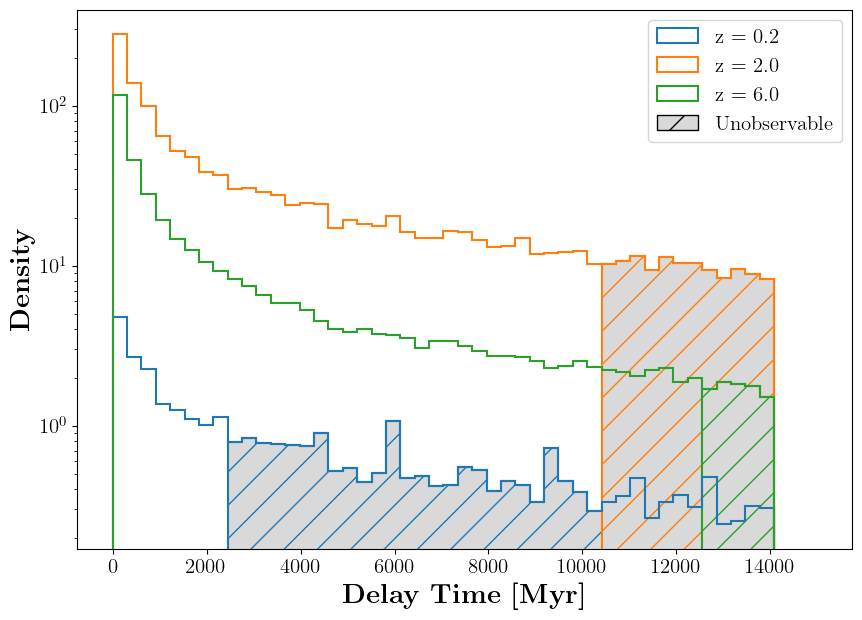

In [9]:
plot_observable_delay_time_distribution(condensed_paths, '2.0', '0.5', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))                               

In [16]:
def plot_observable_delay_time_distribution_with_shape(condensed_paths, alpha_val, beta_val, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # The desired redshifts
    redshifts = ['0.2', '2.0', '6.0']

    bins = np.linspace(0, 15000, 50)
    
    folder_path = path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val
    
    # Dictionary to put all the weights in
    merger_weights = {}

    with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_weights_at_redshifts.h5', 'rb') as f:

        for desired_z in redshifts:
            # Get data
            h5_data = h5.File(f)
            merger_weights[desired_z] = h5_data['redshift_' + desired_z]['total_formation_rates'][...]
    
    # start by getting the necessary data from the COMPAS file
    COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
    COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
    COMPAS.setCOMPASData()
    COMPAS.set_sw_weights(weight_column)
    
    # Mak masks to filer for the channel only
    time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
    t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
        

    ####### Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
    color_labels = ['tab:blue', 'tab:orange', 'tab:green']
    heights = [10**0.32, 10**1.33, 10**0.58]
    
    # Iterate through redshift values and plot delay time distributions
    for index, desired_z in enumerate(redshifts):
        # axis = np.linspace(0, max(t_delay)+10, num=1000)
        # kde = FFTKDE(bw=100).fit(t_delay, weights=merger_weights[desired_z]).evaluate(axis)
        # plt.plot(axis, kde, label='z = ' + desired_z)

        # plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0.5, 3.2, 25), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
        #        alpha=1, lw=1.5)

        ax1.hist(t_delay, weights=merger_weights[desired_z], bins=bins, label='z = ' + desired_z, density=False, histtype='step', facecolor='g',
            edgecolor = mcolors.TABLEAU_COLORS[color_labels[index]], alpha=1, lw=1.5)

        # Get the minimum delay time for mergers at the given redshift to be observable
        lookback_at_z_gyr = cosmology.lookback_time(float(desired_z))
        print('Minimum delay time for z =', desired_z, ':  ', lookback_at_z_gyr)
        # plt.plot(lookback_at_z_gyr*1000, heights[index], marker='*', markersize=18, color=mcolors.TABLEAU_COLORS[color_labels[index]])  # Plot a star at this value

        # Plot a grey box for the unobservable mergers
        min_edge = max(i for i in bins if i <= lookback_at_z_gyr/u.Myr)
        unobservable_mask = [t_delay >= min_edge]
        ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step', facecolor='lightgray',
            edgecolor = 'lightgray', alpha=1, lw=1.5, zorder=-2, fill=True)
        ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step', facecolor='lightgray',
            edgecolor = mcolors.TABLEAU_COLORS[color_labels[index]], alpha=1, lw=1.5, zorder=-1, hatch='/', fill=True)

        ax2.hist(t_delay, weights=merger_weights[desired_z], bins=bins, density=True, histtype='step', facecolor='g',
            alpha=1, lw=1.5)

        # if desired_z == '2.0':
        #     plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0, 1400, 25), label='z = ' + desired_z, zorder=-1, density=True, histtype='step', facecolor='g',
        #        alpha=1, lw=1.5)
        # else:
            # plt.hist(np.log10(t_delay), weights=merger_weights[desired_z], bins=np.linspace(0, 1400, 25), label='z = ' + desired_z, density=True, histtype='step', facecolor='g',
            #    alpha=1, lw=1.5)


    # Format
    unobservable_patch = matplotlib.patches.Patch(facecolor='0.85', edgecolor='k', label='Unobservable', hatch='/')
    plt.legend(fontsize=15)
    h, l = ax1.get_legend_handles_labels()
    h.append(unobservable_patch)
    plt.legend(handles=h, fontsize=15)
    plt.xlabel(r'\textbf{Delay Time [Myr]}', fontsize=22)
    plt.ylabel(r'\textbf{Density}', fontsize=22)
    plt.yscale('log')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax1.set_xlabel(r'\textbf{Delay Time [Myr]}', fontsize=22)
    ax1.set_ylabel(r'\textbf{$d\mathcal{R}_{\rm{merge}}/dt_{\rm{delay}}$}', fontsize=22)
    ax1.set_yscale('log')
    # ax1.set_xscale('log')
    ax2.set_xlabel(r'\textbf{Delay Time [Myr]}', fontsize=22)
    ax2.set_ylabel(r'\textbf{$| d\mathcal{R}_{\rm{merge}} / dt_{\rm{delay}} |$}', fontsize=22)
    ax2.set_yscale('log')
    # ax2.set_xscale('log')
    ax1.tick_params(labelsize=20)
    ax2.tick_params(labelsize=20)

Minimum delay time for z = 0.2 :   2.4605559743096297 Gyr


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_801/3491217839.py:68: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step', facecolor='lightgray',
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_801/3491217839.py:70: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step',

Minimum delay time for z = 2.0 :   10.442114407635646 Gyr


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_801/3491217839.py:68: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step', facecolor='lightgray',
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_801/3491217839.py:70: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step',

Minimum delay time for z = 6.0 :   12.824270497992012 Gyr


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_801/3491217839.py:68: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step', facecolor='lightgray',
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_801/3491217839.py:70: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax1.hist(t_delay[unobservable_mask], weights=merger_weights[desired_z][unobservable_mask], bins=bins, density=False, histtype='step',

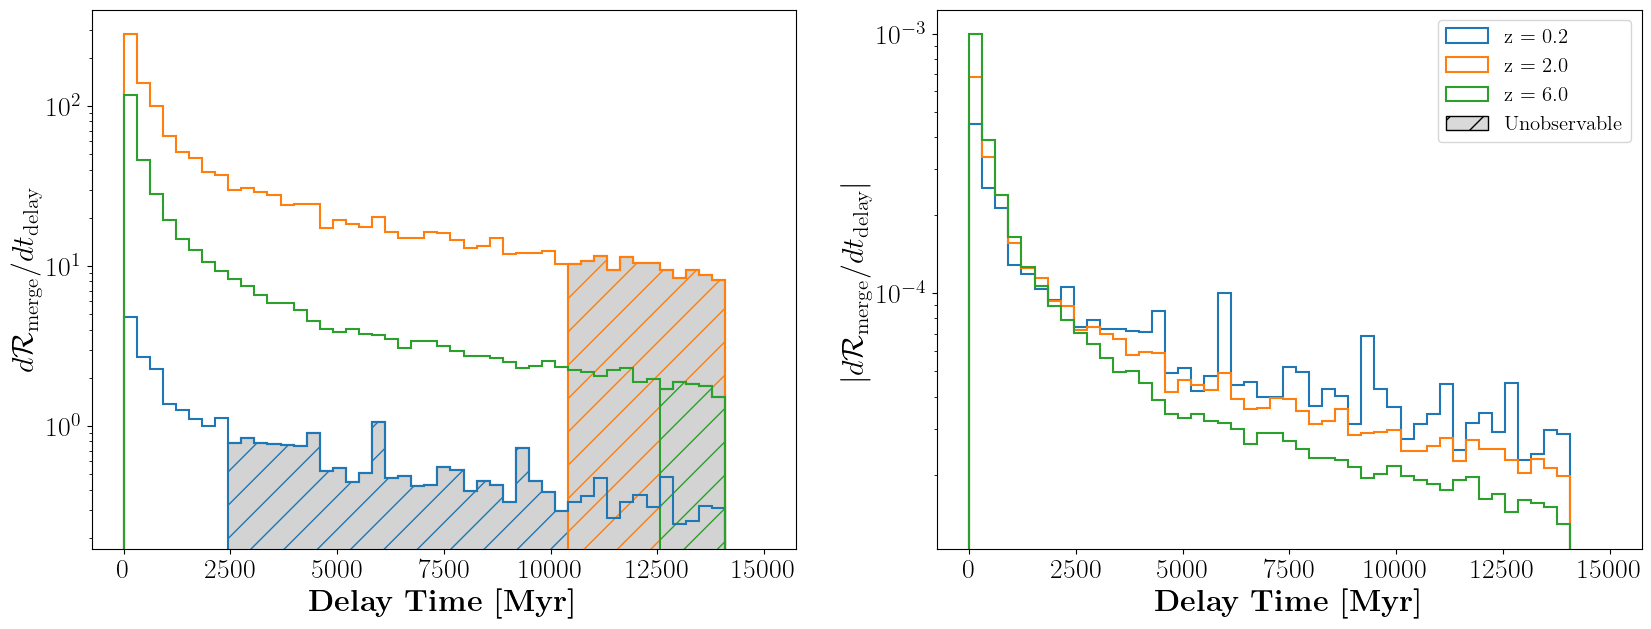

In [17]:
plot_observable_delay_time_distribution_with_shape(condensed_paths, '2.0', '0.5', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

# Plot median $t_\textrm{delay}$ as function of redshift

In [120]:
def weighted_quantile(values, quantiles, sample_weight=None,
                      values_sorted=False, old_style=False):
    """
    FROM FLOOR

    Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'
    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]
    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
        
    return np.interp(quantiles, weighted_quantiles, values)

In [119]:
def plot_t_delay_median_per_z(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS

    quants = [0.005,   0.05,   0.16,   0.25,   0.5,   0.75,   0.84,   0.95,  0.995]
    quantile_estimates = {}
    index = 0

    for alpha_val in alpha_vals:
        quantile_estimates[alpha_val] = {}

        for beta_val in beta_vals:
            folder_path = path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val

            with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/all_rates_weights_at_redshifts.h5', 'rb') as f:
                h5_data = h5.File(f)
                weights = h5_data['actual']['total_formation_rates'][...]
                
                if index == 0:
                    redshifts = h5_data['actual']['redshifts'][...]
            
                # start by getting the necessary data from the COMPAS file
                COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)
                
                # Mak masks to filer for the channel only
                time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
                t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
                index += 1
                quantile_estimates[alpha_val][beta_val] = []
                for z_index, z in enumerate(redshifts):
                    quantile_estimates[alpha_val][beta_val].append(weighted_quantile(t_delay, quants, sample_weight=weights[:,z_index]))

                quantile_estimates[alpha_val][beta_val] = np.array(quantile_estimates[alpha_val][beta_val])
    
    fig = plt.figure(figsize=(14,9))
    dz = redshifts[1] - redshifts[0]
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            
            plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,4], color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            # plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,3], color=color_grid[alpha_val][beta_val], linestyle='dashed')
            # plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,5], color=color_grid[alpha_val][beta_val], linestyle='dashed')
            # plt.plot(redshifts, np.sum(weights,axis=0), color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)

            # scale_factor = np.nansum(quantile_estimates[alpha_val][beta_val][:,4]) * dz
            # plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,4]/scale_factor, color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
            # plt.fill_between(x=redshifts, y1=quantile_estimates[alpha_val][beta_val][:,3], y2=quantile_estimates[alpha_val][beta_val][:,5], alpha=0.2, color=color_grid[alpha_val][beta_val])
            # plt.fill_between(x=redshifts, y1=quantile_estimates[alpha_val][beta_val][:,2], y2=quantile_estimates[alpha_val][beta_val][:,6], alpha=0.2, color=color_grid[alpha_val][beta_val])
            
            plt.ylabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
            plt.xlabel(r'\textbf{Redshift}', fontsize=20)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)

        # Include legend
    leg = fig.legend(fontsize=22, ncol=3, bbox_to_anchor=(0.88, 1.14),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)


    plt.xlim([0, redshifts[-1]])
    plt.ylim([0, plt.ylim()[1]])
    # plt.yscale('log')
                            


In [125]:
def get_data_t_delay_median_per_z(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS

    quants = [0.005,   0.05,   0.16,   0.25,   0.5,   0.75,   0.84,   0.95,  0.995]
    quantile_estimates = {}
    index = 0

    for alpha_val in alpha_vals:
        quantile_estimates[alpha_val] = {}

        for beta_val in beta_vals:
            folder_path = path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val

            with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/all_rates_weights_at_redshifts.h5', 'rb') as f:
                h5_data = h5.File(f)
                weights = h5_data['actual']['total_formation_rates'][...]
                
                if index == 0:
                    redshifts = h5_data['actual']['redshifts'][...]
            
                # start by getting the necessary data from the COMPAS file
                COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)
                
                # Mak masks to filer for the channel only
                time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
                t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
                index += 1
                quantile_estimates[alpha_val][beta_val] = []
                for z_index, z in enumerate(redshifts):
                    quantile_estimates[alpha_val][beta_val].append(weighted_quantile(t_delay, quants, sample_weight=weights[:,z_index]))

                quantile_estimates[alpha_val][beta_val] = np.array(quantile_estimates[alpha_val][beta_val])
                print(f'Done getting data for alpha = {alpha_val}, beta = {beta_val}')
    
    return redshifts, quantile_estimates


def plot_data_t_delay_median_per_z(redshifts, quantile_estimates, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, show_legend=True,
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS

    fig = plt.figure(figsize=(14.5,9))
    dz = redshifts[1] - redshifts[0]

    if dco_type == 'BBH':
        marker_period = 10
    else:
        marker_period = 1000

    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            
            plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,4], color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            # plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,3], color=color_grid[alpha_val][beta_val], linestyle='dashed')
            # plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,5], color=color_grid[alpha_val][beta_val], linestyle='dashed')
            # plt.plot(redshifts, np.sum(weights,axis=0), color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)

            # scale_factor = np.nansum(quantile_estimates[alpha_val][beta_val][:,4]) * dz
            # plt.plot(redshifts, quantile_estimates[alpha_val][beta_val][:,4]/scale_factor, color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
            # plt.fill_between(x=redshifts, y1=quantile_estimates[alpha_val][beta_val][:,3], y2=quantile_estimates[alpha_val][beta_val][:,5], alpha=0.2, color=color_grid[alpha_val][beta_val])
            # plt.fill_between(x=redshifts, y1=quantile_estimates[alpha_val][beta_val][:,2], y2=quantile_estimates[alpha_val][beta_val][:,6], alpha=0.2, color=color_grid[alpha_val][beta_val])
            
            plt.ylabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
            plt.xlabel(r'\textbf{Redshift}', fontsize=20)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)

    # Include legend
    if show_legend:
        leg = fig.legend(fontsize=18, ncol=4, bbox_to_anchor=(0.905, 1.05),  markerscale=1) 
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3.0)
    
    ax = plt.gca()
    redshift_ticks = np.arange(1, 10, 1)
    ax.xaxis.set_ticks(redshift_ticks)

    ax.tick_params(labelsize=18)

    plt.xlim([0, redshifts[-1]])
    plt.ylim([0, plt.ylim()[1]])
    # plt.yscale('log')
                            


In [121]:
redshifts, quantile_estimates = get_data_t_delay_median_per_z(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

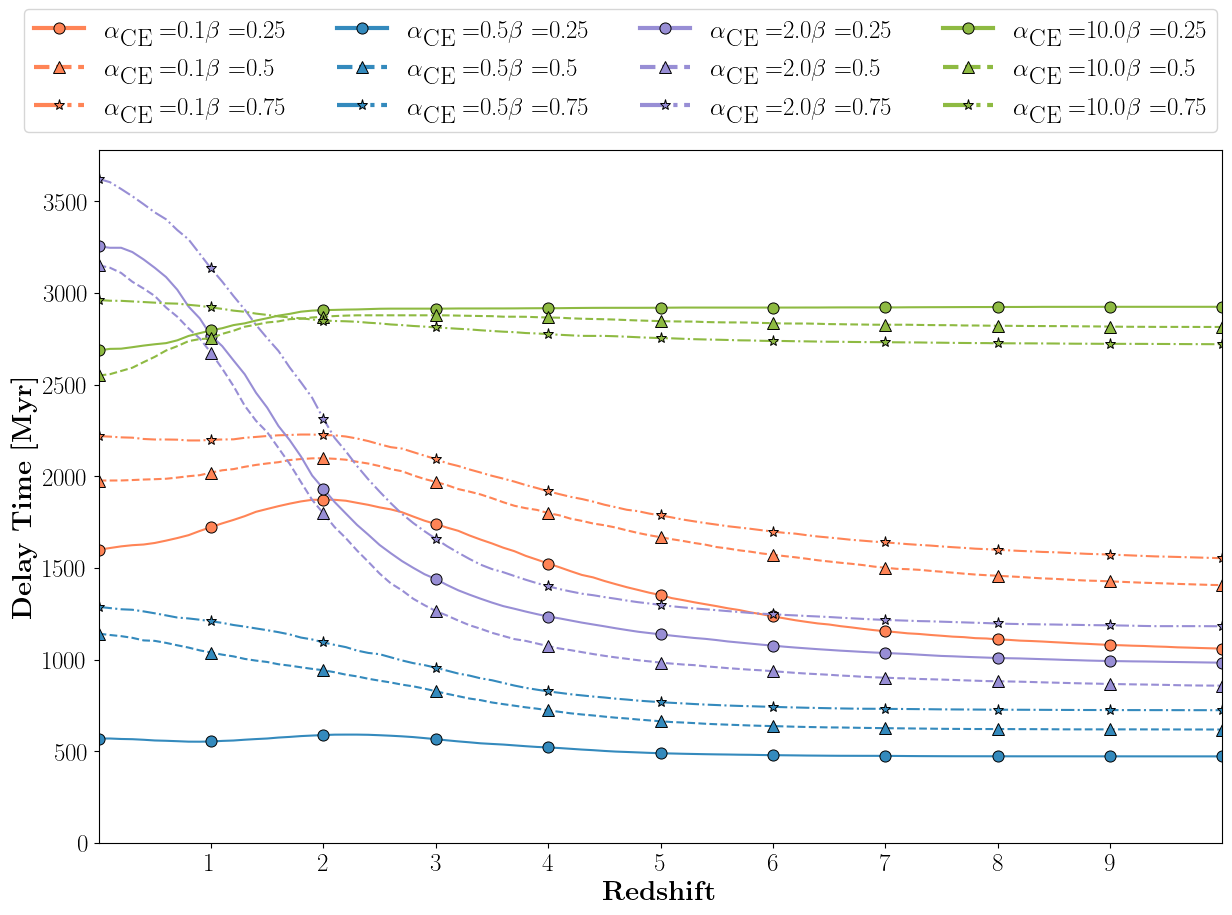

In [158]:
plot_data_t_delay_median_per_z(redshifts, quantile_estimates, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

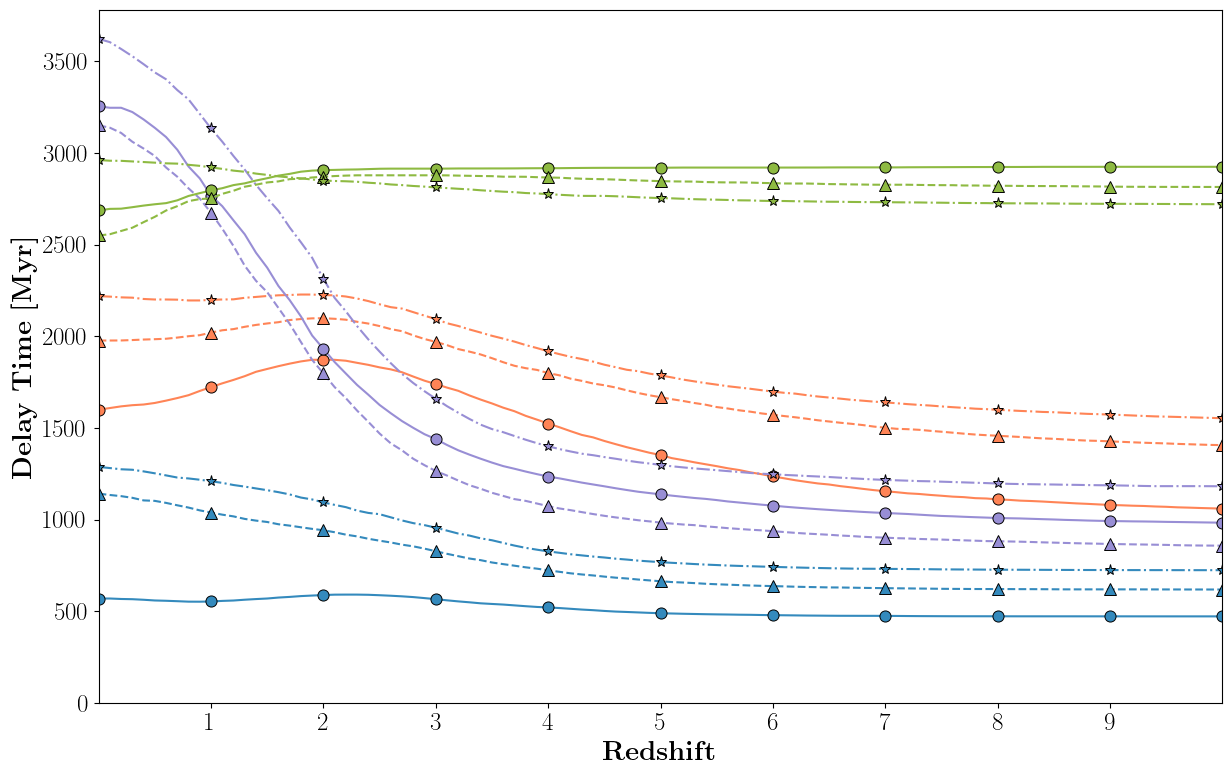

In [126]:
plot_data_t_delay_median_per_z(redshifts, quantile_estimates, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10), show_legend=False)

In [15]:
plot_t_delay_median_per_z(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

NameError: name 'plot_t_delay_median_per_z' is not defined

In [13]:
plot_t_delay_median_per_z(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

NameError: name 'plot_t_delay_median_per_z' is not defined

In [24]:
def get_median_per_z(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS

    quants = [0.5]
    quantile_estimates = {}
    modes = {}
    index = 0

    for alpha_val in alpha_vals:
        quantile_estimates[alpha_val] = {}
        modes[alpha_val] = {}

        for beta_val in beta_vals:
            folder_path = path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val

            with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/all_rates_weights_at_redshifts.h5', 'rb') as f:
                h5_data = h5.File(f)
                weights = h5_data['actual']['total_formation_rates'][...]
                
                if index == 0:
                    redshifts = h5_data['actual']['redshifts'][...]
            
                # start by getting the necessary data from the COMPAS file
                COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)
                
                # Mak masks to filer for the channel only
                time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
                t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
                index += 1
                quantile_estimates[alpha_val][beta_val] = []
                for z_index, z in enumerate(redshifts):
                    quantile_estimates[alpha_val][beta_val].append(weighted_quantile(t_delay, quants, sample_weight=weights[:,z_index]))

                quantile_estimates[alpha_val][beta_val] = np.array(quantile_estimates[alpha_val][beta_val])

    return quantile_estimates

In [26]:
medians = get_median_per_z(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

FileNotFoundError: [Errno 2] No such file or directory: '/n/holystore01/LABS/berger_lab/Users/aboesky/two_parameters/final_alpha_CE_beta/output_alpha_CE_0.1_beta_0.25/Pickled_Rates/MSSFR_111/BBH/all_rates_weights_at_redshifts.h5'

In [30]:
def plot_t_delay_median_per_z_t_delay_specific(condensed_paths, alpha_vals, beta_vals, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=1.5, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS

    quants = [0.005,   0.05,   0.16,   0.25,   0.5,   0.75,   0.84,   0.95,  0.995]
    quantile_estimates = {}
    index = 0

    for alpha_val in alpha_vals:
        quantile_estimates[alpha_val] = {}

        for beta_val in beta_vals:
            folder_path = path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val

            with open(folder_path + '/Pickled_Rates/MSSFR_111/' + dco_type + '/all_rates_weights_at_redshifts.h5', 'rb') as f:
                h5_data = h5.File(f)
                weights = h5_data['actual']['total_merger_rates'][...]
                
                if index == 0:
                    redshifts = h5_data['actual']['redshifts'][...]
            
                # start by getting the necessary data from the COMPAS file
                COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)
                
                # Mak masks to filer for the channel only
                time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
                t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask]
                index += 1
                quantile_estimates[alpha_val][beta_val] = {}
                quantile_estimates[alpha_val][beta_val]['10myr'] = []
                quantile_estimates[alpha_val][beta_val]['100myr'] = []
                quantile_estimates[alpha_val][beta_val]['1gyr'] = []

                t_mask_10myr = t_delay*u.Myr < 50*u.Myr
                t_mask_100myr = t_delay*u.Myr < 100*u.Myr
                t_mask_1gyr = t_delay*u.Myr < 1*u.Gyr

                for z_index, z in enumerate(redshifts):
                    if len(t_delay[t_mask_10myr]) == 0:
                        quantile_estimates[alpha_val][beta_val]['10myr'].append([0,0,0,0,0])
                    else:
                        quantile_estimates[alpha_val][beta_val]['10myr'].append(weighted_quantile(t_delay[t_mask_10myr], quants, sample_weight=weights[:,z_index][t_mask_10myr]))
                    quantile_estimates[alpha_val][beta_val]['100myr'].append(weighted_quantile(t_delay[t_mask_100myr], quants, sample_weight=weights[:,z_index][t_mask_100myr]))
                    quantile_estimates[alpha_val][beta_val]['1gyr'].append(weighted_quantile(t_delay[t_mask_1gyr], quants, sample_weight=weights[:,z_index][t_mask_1gyr]))

                quantile_estimates[alpha_val][beta_val]['10myr'] = np.array(quantile_estimates[alpha_val][beta_val]['10myr'])
                quantile_estimates[alpha_val][beta_val]['100myr'] = np.array(quantile_estimates[alpha_val][beta_val]['100myr'])
                quantile_estimates[alpha_val][beta_val]['1gyr'] = np.array(quantile_estimates[alpha_val][beta_val]['1gyr'])
    

    fig, ax = plt.subplots(1, 3, figsize=(25, 8))
    dz = redshifts[1] - redshifts[0]
    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            
            # <10 Myr
            scale_factor = np.nansum(quantile_estimates[alpha_val][beta_val]['10myr'][:,4]) * dz
            ax[0].plot(redshifts, quantile_estimates[alpha_val][beta_val]['10myr'][:,4]/scale_factor, color=color_grid[alpha_val][beta_val], label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
            
            ax[0].set_xlabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
            ax[0].set_ylabel(r'\textbf{Density}', fontsize=20)
            ax[0].tick_params(axis='both', labelsize=15)

            # <100 Myr
            scale_factor = np.nansum(quantile_estimates[alpha_val][beta_val]['100myr'][:,4]) * dz
            ax[1].plot(redshifts, quantile_estimates[alpha_val][beta_val]['100myr'][:,4]/scale_factor, color=color_grid[alpha_val][beta_val])
            
            ax[1].set_xlabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
            ax[1].set_ylabel(r'\textbf{Density}', fontsize=20)
            ax[1].tick_params(axis='both', labelsize=15)

            # <1 Gyr
            scale_factor = np.nansum(quantile_estimates[alpha_val][beta_val]['1gyr'][:,4]) * dz
            ax[2].plot(redshifts, quantile_estimates[alpha_val][beta_val]['1gyr'][:,4]/scale_factor, color=color_grid[alpha_val][beta_val])
            
            ax[2].set_xlabel(r'\textbf{Delay Time [Myr]}', fontsize=20)
            ax[2].set_ylabel(r'\textbf{Density}', fontsize=20)
            ax[2].tick_params(axis='both', labelsize=15)


        # Include legend
    leg = fig.legend(fontsize=22, ncol=5, bbox_to_anchor=(0.87, 1.11),  markerscale=25) 
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)
                            


In [8]:
plot_t_delay_median_per_z_t_delay_specific(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.6), panel2_range=(10**-1.6, 10))

NameError: name 'plot_t_delay_median_per_z_t_delay_specific' is not defined

# Uniformly distrubuted delay times

In [11]:
def plot_pickled_frates_sfr_norm(condensed_paths, alpha_vals, beta_vals, sfr_redshifts_kde, sfr_kde, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, show_legend=True, legend_2_label='SFR',
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_formation_rates = {}
    total_detection_rates = {}
    cumulative_detection_rates = {}
    detection_rates_by_binary = {}
    mass_kde_scaled = {}
    redshifts = {}
    Mc_bins = {}
    one_sigma = {}
    two_sigma = {}

    for alpha_index, alpha_val in enumerate(alpha_vals):
        # Make the dictionary "2D"
        total_formation_rates[alpha_val] = {}
        total_detection_rates[alpha_val] = {}
        cumulative_detection_rates[alpha_val] = {}
        detection_rates_by_binary[alpha_val] = {}
        mass_kde_scaled[alpha_val] = {}
        Mc_bins[alpha_val] = {}
        one_sigma[alpha_val] = {}
        two_sigma[alpha_val] = {}

        redshifts[alpha_val] = {}

        for beta_index, beta_val in enumerate(beta_vals):
            one_sigma[alpha_val][beta_val] = {}
            two_sigma[alpha_val][beta_val] = {}
        
            with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps.h5', 'rb') as f:
                # Get data
                h5_data = h5.File(f)
                total_formation_rates[alpha_val][beta_val] = h5_data['Actual']['total_formation_rates'][...]
                # redshifts[alpha_val][beta_val] = dict['redshfits']
                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]
                cumulative_detection_rates[alpha_val][beta_val] = h5_data['Actual']['cumulative_detection_rates'][...]
                mass_kde_scaled[alpha_val][beta_val] = h5_data['Actual']['mass_kde_scaled'][...]

                # Declare bins for the chirp mass KDE
                COMPAS = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)            
                chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3./5.) / (COMPAS.mass1 + COMPAS.mass2)**(1./5.)
                Mc_bins[alpha_val][beta_val] = np.arange(0, max(chirp_masses)*1.3, max(chirp_masses)*1.2/100) # We need to pass in the bins for the chirp mass distribution so we will declare them here

                # empty trash
                del chirp_masses
                del COMPAS

                # Calculate confidence intervals
                one_sigma[alpha_val][beta_val]['total_formation_rates']          =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [16, 84], axis=0)

                # Get the two sigma confidence intervals
                two_sigma[alpha_val][beta_val]['total_formation_rates']          =   np.percentile(h5_data['Bootstraps']['total_formation_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [2.5, 97.5], axis=0)

            # # Delete trash object
            # del COMPASs



    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 24
    tickLengthMajor = 7
    tickLengthMinor = 3.5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    # Get redshifts to use for the SFR
    sfr_redshifts = redshifts['0.1']['0.5']

    # Retreive the SFR
    # MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
    # MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
    # ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages
    # sfr = MSSFR.returnSFR(sfr_redshifts, ages)              # Get the SFR
    sfr = np.interp(sfr_redshifts, sfr_redshifts_kde, sfr_kde)
    sfr_area = np.trapz(sfr, x=sfr_redshifts)               # Get the area under the curve
    sfr_normalized = sfr/sfr_area                           # Make it so the area under the curve is 1
    if dco_type == 'BBH':
        marker_period = 10
    else:
        marker_period = 1000

    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            # Plot each of the panels, and their confidence intervals
            axes[0].plot(redshifts[alpha_val][beta_val], total_formation_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[0].fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_formation_rates'][0], y2=one_sigma[alpha_val][beta_val]['total_formation_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[0].fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_formation_rates'][0], y2=two_sigma[alpha_val][beta_val]['total_formation_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])

            merger_rate_area = np.trapz(total_formation_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            axes[1].plot(redshifts[alpha_val][beta_val], (total_formation_rates[alpha_val][beta_val] / merger_rate_area) / sfr_normalized, lw=lw, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[1].fill_between(x=redshifts[alpha_val][beta_val], y1=(one_sigma[alpha_val][beta_val]['total_formation_rates'][0] / merger_rate_area) / sfr_normalized, y2=(one_sigma[alpha_val][beta_val]['total_formation_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[1].fill_between(x=redshifts[alpha_val][beta_val], y1=(two_sigma[alpha_val][beta_val]['total_formation_rates'][0] / merger_rate_area) / sfr_normalized, y2=(two_sigma[alpha_val][beta_val]['total_formation_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])

    
    # Label axes of all the plots
    axes[0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[0].set_ylabel(r'\textbf{$\mathcal{R}_{\rm{form}}  \ \  [\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
    axes[0].set_yscale('log')

    axes[1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[1].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{form}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)
    axes[1].set_yscale('log')

    # Set lower bounds for the plots
    if panel1_range:
        axes[0].set_ylim(panel1_range)
    if panel2_range:
        axes[1].set_ylim(panel2_range)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)
        ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    
    redshift_ticks = np.arange(1, 10, 1)
    axes[0].xaxis.set_ticks(redshift_ticks)
    axes[1].xaxis.set_ticks(redshift_ticks)
    
    axes[0].set_xlim((0,10))
    axes[1].set_xlim((0,10))
    
    # Scale SFR differently for each DCO type
    sfr = sfr/max(sfr)
    merger_const = axes[0].get_ylim()[1] * 0.5

    # Plot SFRs
    sfr_line = axes[0].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3)
    legend2 = axes[0].legend(sfr_line, [legend_2_label], fontsize=22, loc='upper right')

    # Plot horizontal line for SFR on the normalized plots
    axes[1].axhline(y=1, color='darkgray', lw=3, zorder=-1)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)

    # Include legend
    if show_legend:
        leg = fig.legend(fontsize=22, ncol=4, bbox_to_anchor=(0.875, 1.25),  markerscale=1) 
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3.0)

    # Add lookback time axis
    ax_top1 = add_lookback_t_axes(axes[0], labelsize=fs)
    ax_top2 = add_lookback_t_axes(axes[1], labelsize=fs)
    for ax_top in (ax_top1, ax_top2):
        ax_top.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax_top.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')


    axes[0].grid()
    axes[1].grid()

    # Show the plot!
    plt.show()

In [12]:
def plot_pickled_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, sfr_redshifts_kde, sfr_kde, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, show_legend=True, legend_2_label='SFR', figsize=(20, 7),
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_merger_rates = {}
    total_detection_rates = {}
    cumulative_detection_rates = {}
    detection_rates_by_binary = {}
    mass_kde_scaled = {}
    redshifts = {}
    Mc_bins = {}
    one_sigma = {}
    two_sigma = {}

    for alpha_index, alpha_val in enumerate(alpha_vals):
        # Make the dictionary "2D"
        total_merger_rates[alpha_val] = {}
        total_detection_rates[alpha_val] = {}
        cumulative_detection_rates[alpha_val] = {}
        detection_rates_by_binary[alpha_val] = {}
        mass_kde_scaled[alpha_val] = {}
        Mc_bins[alpha_val] = {}
        one_sigma[alpha_val] = {}
        two_sigma[alpha_val] = {}

        redshifts[alpha_val] = {}

        for beta_index, beta_val in enumerate(beta_vals):
            one_sigma[alpha_val][beta_val] = {}
            two_sigma[alpha_val][beta_val] = {}
        
            with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps.h5', 'rb') as f:
                # Get data
                h5_data = h5.File(f)
                total_merger_rates[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...]
                # redshifts[alpha_val][beta_val] = dict['redshfits']
                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]
                cumulative_detection_rates[alpha_val][beta_val] = h5_data['Actual']['cumulative_detection_rates'][...]
                mass_kde_scaled[alpha_val][beta_val] = h5_data['Actual']['mass_kde_scaled'][...]

                # Declare bins for the chirp mass KDE
                COMPAS = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)            
                chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3./5.) / (COMPAS.mass1 + COMPAS.mass2)**(1./5.)
                Mc_bins[alpha_val][beta_val] = np.arange(0, max(chirp_masses)*1.3, max(chirp_masses)*1.2/100) # We need to pass in the bins for the chirp mass distribution so we will declare them here

                # empty trash
                del chirp_masses
                del COMPAS

                # Calculate confidence intervals
                one_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [16, 84], axis=0)

                # Get the two sigma confidence intervals
                two_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [2.5, 97.5], axis=0)

            # # Delete trash object
            # del COMPASs



    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 24
    tickLengthMajor = 7
    tickLengthMinor = 3.5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Get redshifts to use for the SFR
    sfr_redshifts = redshifts['0.1']['0.5']

    # Retreive the SFR
    # MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
    # MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
    # ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages
    # sfr = MSSFR.returnSFR(sfr_redshifts, ages)              # Get the SFR
    sfr = np.interp(sfr_redshifts, sfr_redshifts_kde, sfr_kde)
    sfr_area = np.trapz(sfr, x=sfr_redshifts)               # Get the area under the curve
    sfr_normalized = sfr/sfr_area                           # Make it so the area under the curve is 1
    if dco_type == 'BBH':
        marker_period = 10
    else:
        marker_period = 1000

    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            # Plot each of the panels, and their confidence intervals
            axes[0].plot(redshifts[alpha_val][beta_val], total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[0].fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=one_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[0].fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=two_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])

            merger_rate_area = np.trapz(total_merger_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            axes[1].plot(redshifts[alpha_val][beta_val], (total_merger_rates[alpha_val][beta_val] / merger_rate_area) / sfr_normalized, lw=lw, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[1].fill_between(x=redshifts[alpha_val][beta_val], y1=(one_sigma[alpha_val][beta_val]['total_merger_rates'][0] / merger_rate_area) / sfr_normalized, y2=(one_sigma[alpha_val][beta_val]['total_merger_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[1].fill_between(x=redshifts[alpha_val][beta_val], y1=(two_sigma[alpha_val][beta_val]['total_merger_rates'][0] / merger_rate_area) / sfr_normalized, y2=(two_sigma[alpha_val][beta_val]['total_merger_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])

    
    # Label axes of all the plots
    axes[0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[0].set_ylabel(r'\textbf{$\mathcal{R}_{\rm{merge}}  \ \  [\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
    axes[0].set_yscale('log')

    axes[1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[1].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{merge}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)
    axes[1].set_yscale('log')

    # Set lower bounds for the plots
    if panel1_range:
        axes[0].set_ylim(panel1_range)
    if panel2_range:
        axes[1].set_ylim(panel2_range)

    for ax in axes.flatten():
            ax.tick_params(labelsize=fs*0.9)

    redshift_ticks = np.arange(1, 10, 1)
    axes[0].xaxis.set_ticks(redshift_ticks)
    axes[1].xaxis.set_ticks(redshift_ticks)

    axes[0].set_xlim((0,10))
    axes[1].set_xlim((0,10))
    
    # Scale SFR differently for each DCO type
    sfr = sfr/max(sfr)
    merger_const = axes[0].get_ylim()[1] * 0.45

    # Plot SFRs
    sfr_line = axes[0].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3)
    legend2 = axes[0].legend(sfr_line, [legend_2_label], fontsize=22, loc='upper right')

    # Plot horizontal line for SFR on the normalized plots
    axes[1].axhline(y=1, color='darkgray', lw=3, zorder=-1)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)
        ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')

    # Include legend
    if show_legend:
        leg = fig.legend(fontsize=22, ncol=4, bbox_to_anchor=(0.875, 1.25),  markerscale=1) 
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3.0)

    # Add lookback time axis
    ax_top1 = add_lookback_t_axes(axes[0], labelsize=fs)
    ax_top2 = add_lookback_t_axes(axes[1], labelsize=fs)
    for ax_top in (ax_top1, ax_top2):
        ax_top.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax_top.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')

    axes[0].grid()
    axes[1].grid()

    # Show the plot!
    plt.show()

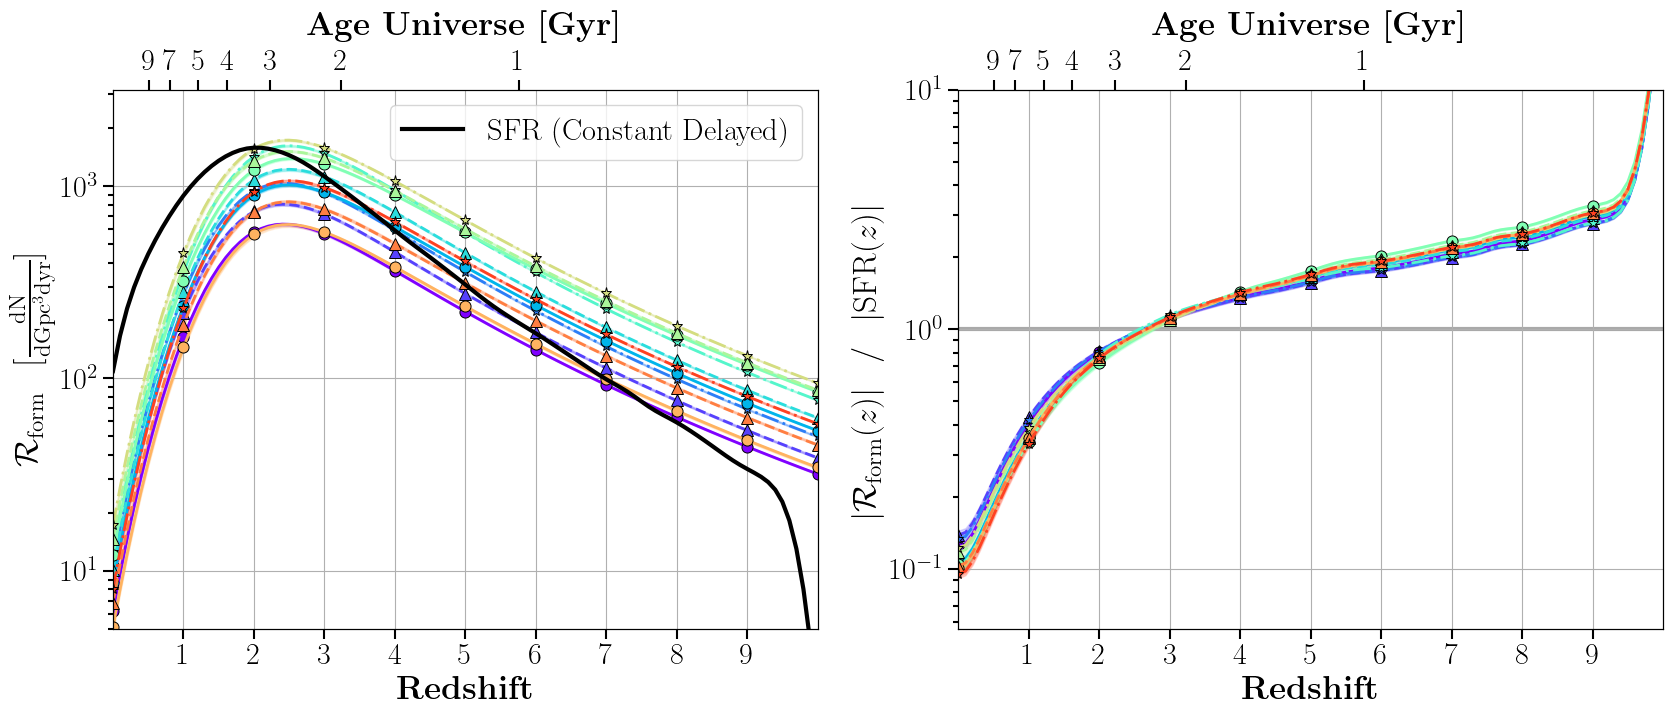

In [13]:
plot_pickled_frates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', sfr_redshifts_kde=uniform_delayed_sfrs['axis'], sfr_kde=uniform_delayed_sfrs['20'], weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step,
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(5, 10**3.5), panel2_range=(10**-1.25, 10), show_legend=False, legend_2_label='SFR (Constant Delayed)')

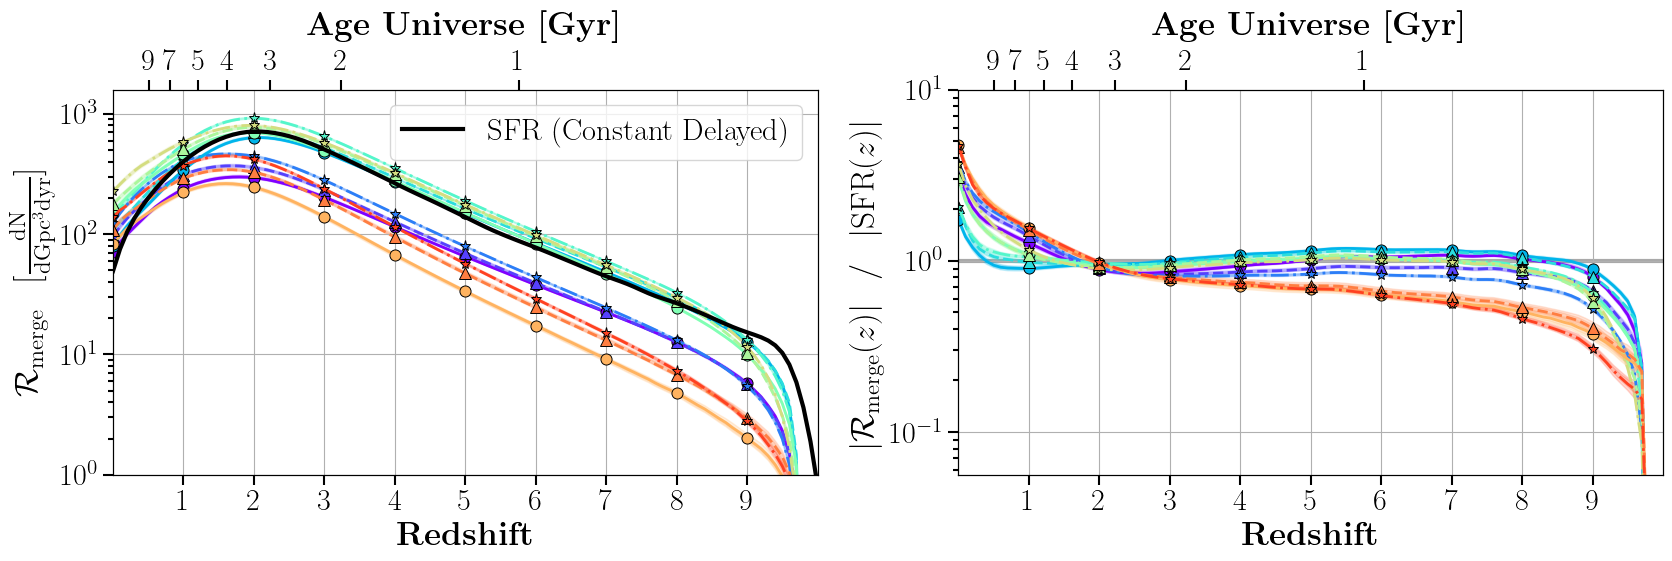

In [14]:
plot_pickled_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', sfr_redshifts_kde=uniform_delayed_sfrs['axis'], sfr_kde=uniform_delayed_sfrs['20'], weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step,
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.2), panel2_range=(10**-1.25, 10), show_legend=False, legend_2_label='SFR (Constant Delayed)', figsize=(20,5))

# $T^{-1}$ randomly distributed delay times

In [16]:
alpha_vals = ['0.1', '0.5', '2.0', '10.0'] # All the alpha values
beta_vals = ['0.25', '0.5', '0.75'] # All the beta values
t_delays = []

for alpha_val in alpha_vals:
    for beta_val in beta_vals:
        # The desired redshifts
        redshifts = ['0.2', '2.0', '6.0']

        folder_path = path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val

        # Dictionary to put all the weights in
        merger_weights = {}

        # with open(folder_path + '/Pickled_Rates/MSSFR_111/BBH/rates_weights_at_redshifts.h5', 'rb') as f:

        #     for desired_z in redshifts:
        #         # Get data
        #         h5_data = h5.File(f)
        #         merger_weights[desired_z] = h5_data['redshift_' + desired_z]['total_formation_rates'][...]

        # start by getting the necessary data from the COMPAS file
        COMPAS = ClassCOMPAS.COMPASData(folder_path + '/COMPAS_Output_Weighted.h5', Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
        COMPAS.setCOMPASDCOmask(types='BBH', withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
        COMPAS.setCOMPASData()
        COMPAS.set_sw_weights(weight_column)

        # Mak masks to filer for the channel only
        time, coalescence_time = COMPAS.get_COMPAS_variables("BSE_Double_Compact_Objects",["Time", "Coalescence_Time"])
        t_delay = time[COMPAS.DCOmask] + coalescence_time[COMPAS.DCOmask] # Myr
        t_delays = t_delays + list(t_delay)

t_delay_max = max(t_delays)
t_delay_min = min(t_delays)

In [18]:
print('From our data:\n')
print('min t_delay =', t_delay_min, 'Myr')
print('max t_delay =', t_delay_max, 'Myr')

From our data:

min t_delay = 4.705465211045611 Myr
max t_delay = 14034.336393448983 Myr


We will assume a minimum delay time of $20$ Myr according to Regimbau 2012 et al., Lacovelli 2022 et al.

In [57]:
t_delay_min = 20  # Myr

In [20]:
def draw_t_inv(t_delay_min, t_delay_max, t_unit, size=1E6):
    u = np.random.uniform(low=np.log(t_delay_min), high=np.log(t_delay_max), size=int(size))
    tinv = np.e**u

    if t_unit.lower() == 'myr':
        return tinv
    elif t_unit.lower() == 'yr':
        return tinv * 1E6

In [21]:
t_inv = draw_t_inv(t_delay_min, t_delay_max, t_unit='myr', size=1E7)

In [22]:
test = np.random.uniform(low=-1, high=10, size=int(1E6))

In [23]:
tinv = np.e**test

(array([644683.,  62812.,  36692.,  25988.,  20398.,  16605.,  14012.,
         12089.,  10717.,   9749.,   8699.,   7940.,   7256.,   6815.,
          6208.,   5866.,   5569.,   5252.,   4871.,   4674.,   4392.,
          4248.,   3977.,   3844.,   3663.,   3479.,   3386.,   3298.,
          3067.,   3052.,   2940.,   2967.,   2819.,   2792.,   2642.,
          2534.,   2531.,   2407.,   2375.,   2334.,   2243.,   2264.,
          2127.,   2046.,   2027.,   2047.,   2000.,   1870.,   1895.,
          1839.]),
 array([3.67883238e-01, 4.40888262e+02, 8.81408642e+02, 1.32192902e+03,
        1.76244940e+03, 2.20296978e+03, 2.64349016e+03, 3.08401054e+03,
        3.52453092e+03, 3.96505130e+03, 4.40557168e+03, 4.84609205e+03,
        5.28661243e+03, 5.72713281e+03, 6.16765319e+03, 6.60817357e+03,
        7.04869395e+03, 7.48921433e+03, 7.92973471e+03, 8.37025509e+03,
        8.81077547e+03, 9.25129585e+03, 9.69181623e+03, 1.01323366e+04,
        1.05728570e+04, 1.10133774e+04, 1.14538977e+

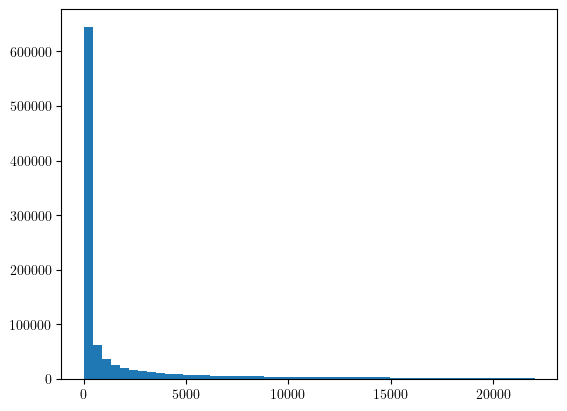

In [24]:
plt.hist(tinv, 50)

In [31]:
sfr_sample_delays = draw_t_inv(t_delay_min, t_delay_max, 'yr', size=sample_size)
print(sfr_sample_delays)

[9.88775844e+07 4.73091936e+09 1.47568587e+09 ... 2.94685847e+07
 1.32770850e+08 1.86056659e+08]


In [33]:
sample_size = len(sfr_sample)
sfr_sample_delays = draw_t_inv(t_delay_min, t_delay_max, 'myr', size=sample_size)
sfr_sample_yrs = cosmology.age(sfr_sample).to(u.Myr).value

print(sfr_sample_yrs)
print(sfr_sample_delays)
ages_t_inv = sfr_sample_yrs * u.Myr + sfr_sample_delays * u.Myr
sfr_t_inv = z_at_value(cosmology.age, ages_t_inv, zmin=-1)

[13767.22070685 13766.50147566 13766.40276175 ...   479.30593188
   479.29839648   479.20621838]
[ 65.18105518 178.37881308 885.82055063 ...  73.22544505 367.23315859
 639.4502418 ]


/Users/adamboesky/opt/anaconda3/envs/PRISE/lib/python3.9/site-packages/astropy/cosmology/flrw/base.py:1057: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(self._lookback_time_integrand_scalar, z, inf)[0]


In [34]:
sfr_axis = np.arange(-1, 10.1, 0.01)
sfr_tinv_kde = FFTKDE().fit(sfr_t_inv).evaluate(sfr_axis)
test = FFTKDE().fit(sfr_sample).evaluate(sfr_axis)

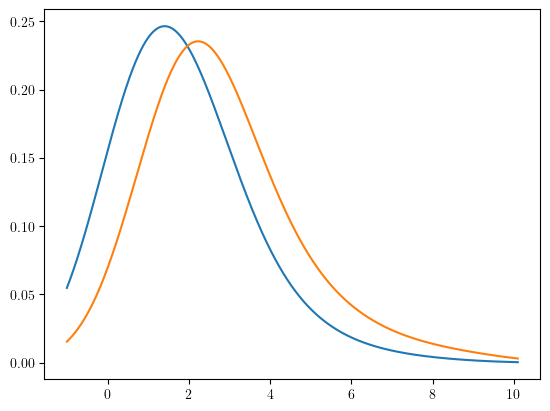

In [37]:
plt.plot(sfr_axis, sfr_tinv_kde)
plt.plot(sfr_axis,test)

In [39]:
with open("t_inv_sfr.pkl", "wb") as f:
    pickle.dump({'sfr_tinv_kde': sfr_tinv_kde, 'sfr_t_inv': sfr_t_inv}, f)

(array([ 2288., 20975., 27392., 30330., 32545., 33941., 33493., 30074.,
        25185., 20220., 15418., 11464.,  8836.,  6694.,  5017.,  3902.,
         3064.,  2361.,  1851.,  1498.,  1107.,   860.,   733.,   556.,
          412.,   346.,   238.,   186.,   110.,    44.]),
 <Quantity [-0.57697448, -0.23497166,  0.10703116,  0.44903399,  0.79103681,
             1.13303963,  1.47504245,  1.81704527,  2.1590481 ,  2.50105092,
             2.84305374,  3.18505656,  3.52705939,  3.86906221,  4.21106503,
             4.55306785,  4.89507067,  5.2370735 ,  5.57907632,  5.92107914,
             6.26308196,  6.60508479,  6.94708761,  7.28909043,  7.63109325,
             7.97309607,  8.3150989 ,  8.65710172,  8.99910454,  9.34110736,
             9.68311019] redshift>,
 <BarContainer object of 30 artists>)

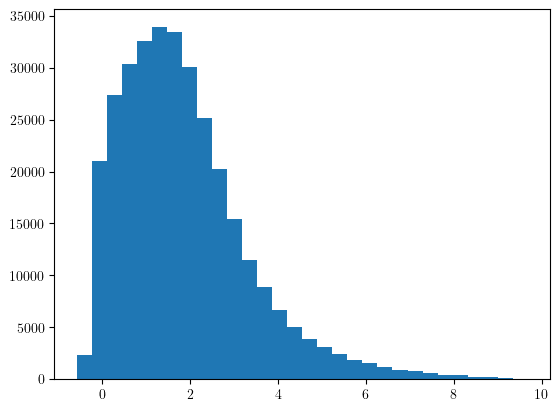

In [40]:
plt.hist(sfr_t_inv, 30)

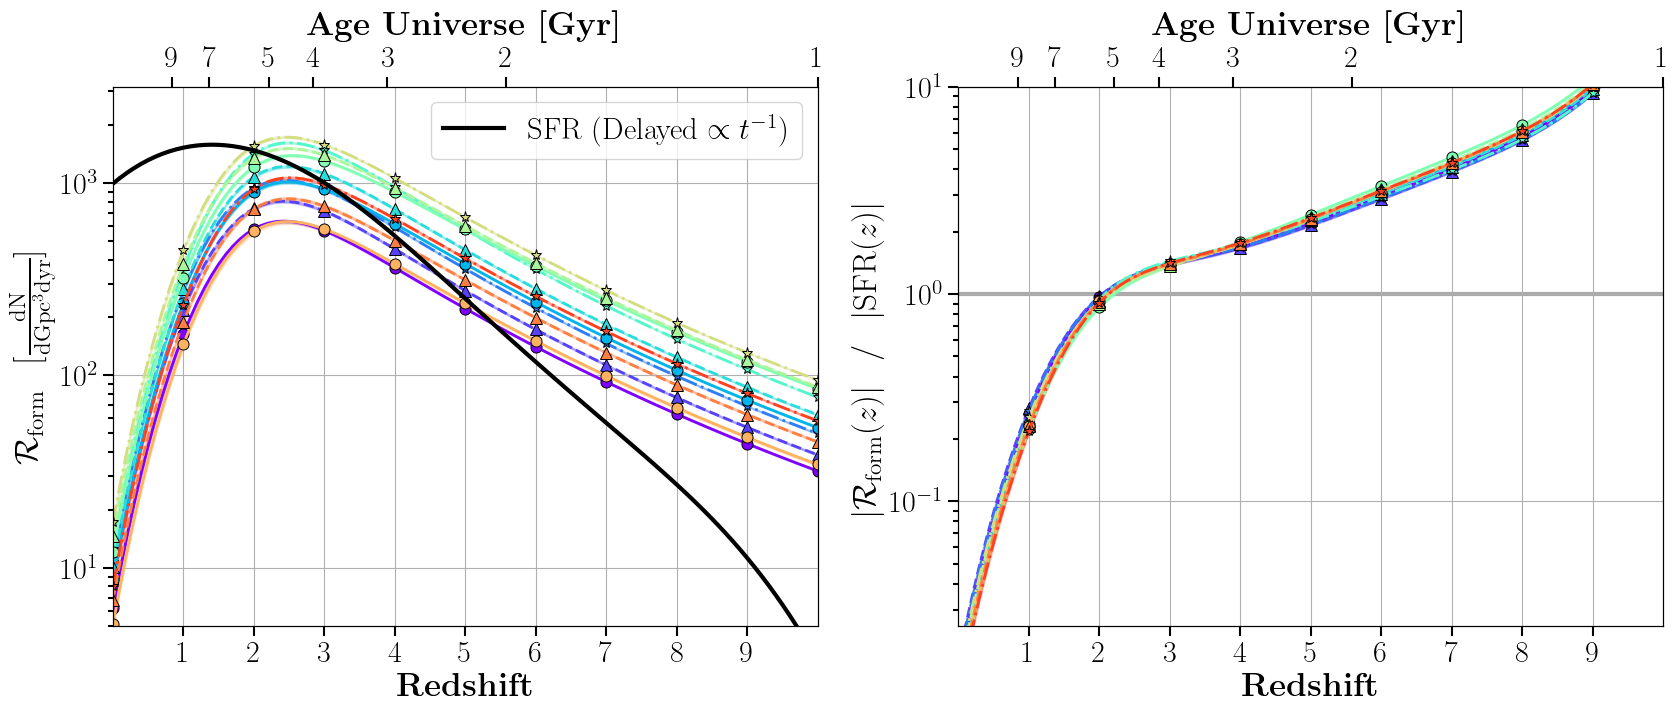

In [86]:
plot_pickled_frates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', sfr_redshifts_kde=sfr_axis, sfr_kde=tinv_delayed_sfrs['20'][1], weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step,
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(5, 10**3.5), panel2_range=(10**-1.6, 10), show_legend=False, legend_2_label=r'SFR (Delayed $\propto t^{-1}$)')

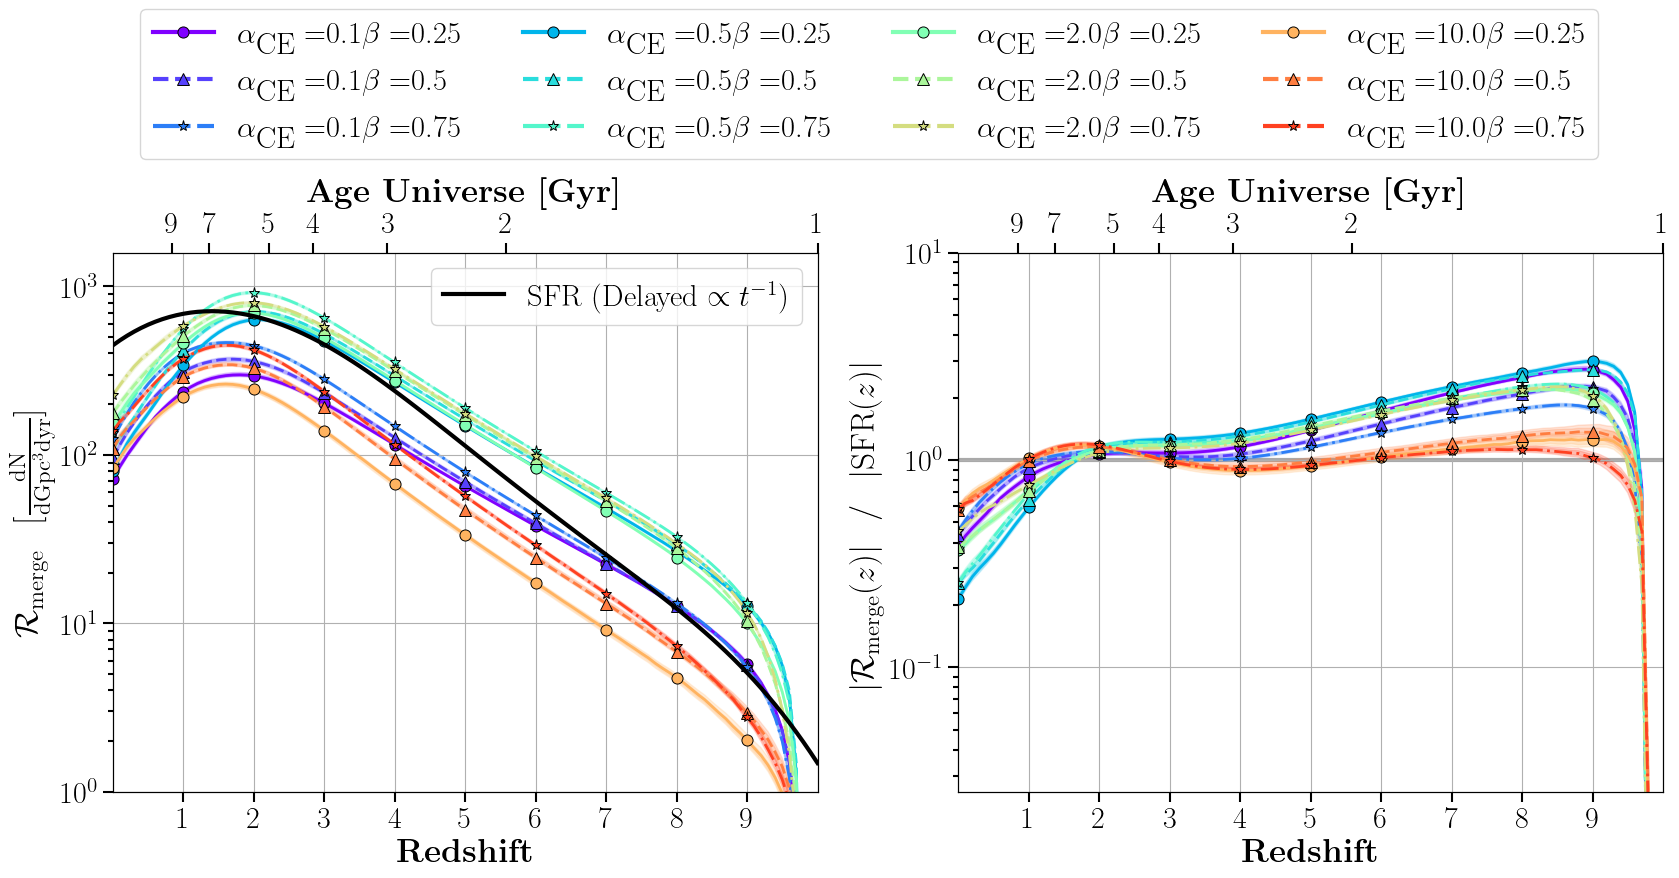

In [87]:
plot_pickled_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', sfr_redshifts_kde=sfr_axis, sfr_kde=tinv_delayed_sfrs['20'][1], weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step,
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.2), panel2_range=(10**-1.6, 10), legend_2_label=r'SFR (Delayed $\propto t^{-1}$)')

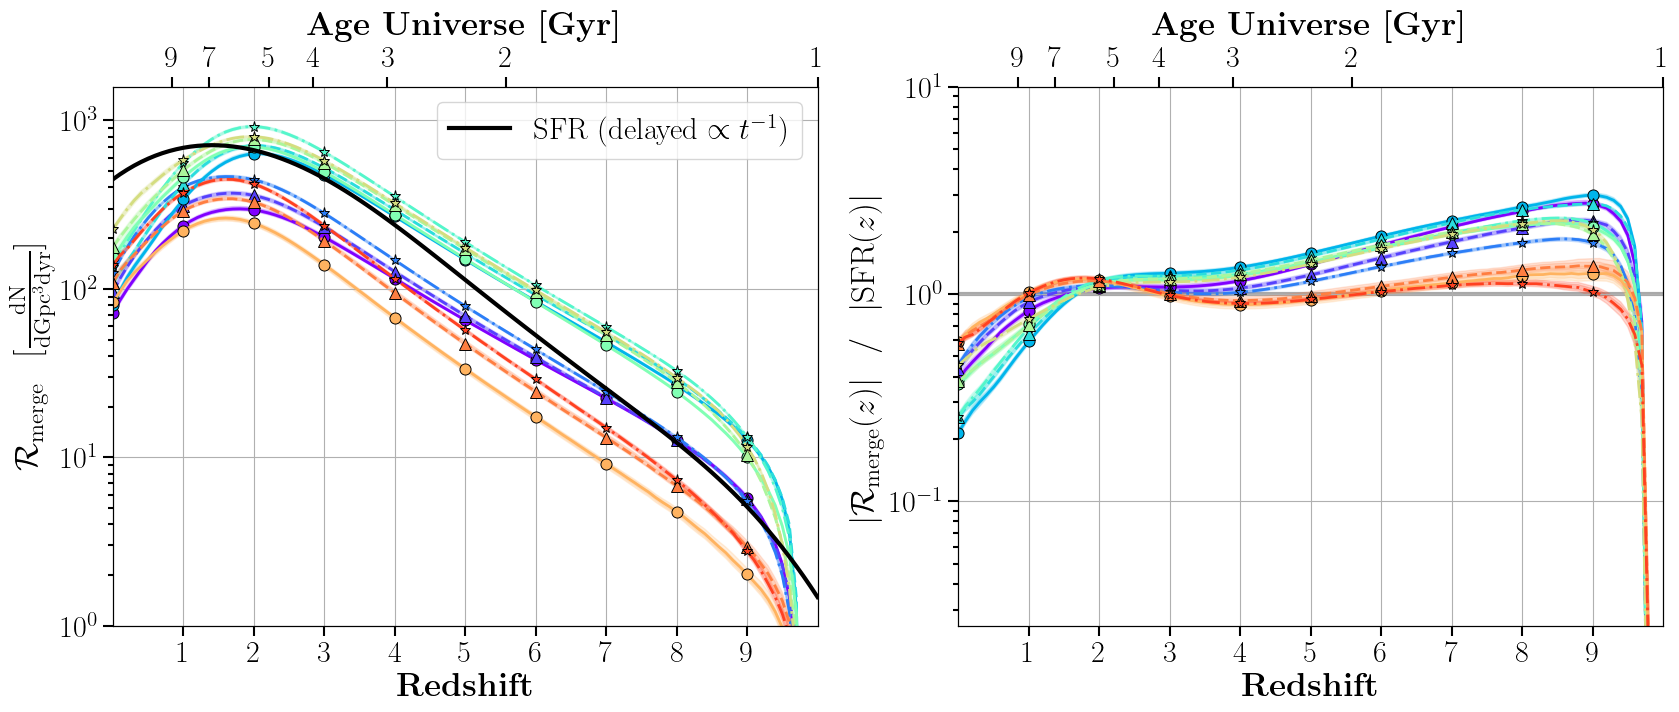

In [85]:
plot_pickled_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', sfr_redshifts_kde=sfr_axis, sfr_kde=tinv_delayed_sfrs['20'][1], weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step,
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.2), panel2_range=(10**-1.6, 10), show_legend=False, legend_2_label=r'SFR (delayed $\propto t^{-1}$)')

# Figure with both uniform and $\propto t^{-1}$

In [20]:
def plot_delayed_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, sfr_redshifts_kde_uniform, sfr_kde_uniform, sfr_redshifts_kde_tinv, sfr_kde_tinv, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, show_legend=True, figsize=(20, 10),
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_merger_rates = {}
    total_detection_rates = {}
    cumulative_detection_rates = {}
    detection_rates_by_binary = {}
    mass_kde_scaled = {}
    redshifts = {}
    Mc_bins = {}
    one_sigma = {}
    two_sigma = {}

    for alpha_index, alpha_val in enumerate(alpha_vals):
        # Make the dictionary "2D"
        total_merger_rates[alpha_val] = {}
        total_detection_rates[alpha_val] = {}
        cumulative_detection_rates[alpha_val] = {}
        detection_rates_by_binary[alpha_val] = {}
        mass_kde_scaled[alpha_val] = {}
        Mc_bins[alpha_val] = {}
        one_sigma[alpha_val] = {}
        two_sigma[alpha_val] = {}

        redshifts[alpha_val] = {}

        for beta_index, beta_val in enumerate(beta_vals):
            one_sigma[alpha_val][beta_val] = {}
            two_sigma[alpha_val][beta_val] = {}
        
            with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps.h5', 'rb') as f:
                # Get data
                h5_data = h5.File(f)
                total_merger_rates[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...]
                # redshifts[alpha_val][beta_val] = dict['redshfits']
                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]
                cumulative_detection_rates[alpha_val][beta_val] = h5_data['Actual']['cumulative_detection_rates'][...]
                mass_kde_scaled[alpha_val][beta_val] = h5_data['Actual']['mass_kde_scaled'][...]

                # Declare bins for the chirp mass KDE
                COMPAS = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)            
                chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3./5.) / (COMPAS.mass1 + COMPAS.mass2)**(1./5.)
                Mc_bins[alpha_val][beta_val] = np.arange(0, max(chirp_masses)*1.3, max(chirp_masses)*1.2/100) # We need to pass in the bins for the chirp mass distribution so we will declare them here

                # empty trash
                del chirp_masses
                del COMPAS

                # Calculate confidence intervals
                one_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [16, 84], axis=0)

                # Get the two sigma confidence intervals
                two_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [2.5, 97.5], axis=0)

            # # Delete trash object
            # del COMPASs



    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 24
    tickLengthMajor = 7
    tickLengthMinor = 3.5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Get redshifts to use for the SFR
    sfr_redshifts = redshifts['0.1']['0.5']

    # Retreive the SFR
    # MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
    # MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
    # ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages
    # sfr = MSSFR.returnSFR(sfr_redshifts, ages)              # Get the SFR
    for row, sfr_redshifts_kde, sfr_kde, legend_2_label in [(0, sfr_redshifts_kde_uniform, sfr_kde_uniform, r'SFR (constant delay)'), (1, sfr_redshifts_kde_tinv, sfr_kde_tinv, r'SFR (delayed $\propto t^{-1}$)')]:
        sfr = np.interp(sfr_redshifts, sfr_redshifts_kde, sfr_kde)
        sfr_area = np.trapz(sfr, x=sfr_redshifts)               # Get the area under the curve
        sfr_normalized = sfr/sfr_area                           # Make it so the area under the curve is 1
        if dco_type == 'BBH':
            marker_period = 10
        else:
            marker_period = 1000

        for alpha_val in alpha_vals:
            for beta_val in beta_vals:
                # Plot each of the panels, and their confidence intervals
                axes[row, 0].plot(redshifts[alpha_val][beta_val], total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
                axes[row, 0].fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=one_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])
                axes[row, 0].fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_merger_rates'][0], y2=two_sigma[alpha_val][beta_val]['total_merger_rates'][1], alpha=0.2, color=color_grid[alpha_val][beta_val])

                merger_rate_area = np.trapz(total_merger_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
                axes[row, 1].plot(redshifts[alpha_val][beta_val], (total_merger_rates[alpha_val][beta_val] / merger_rate_area) / sfr_normalized, lw=lw, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
                axes[row, 1].fill_between(x=redshifts[alpha_val][beta_val], y1=(one_sigma[alpha_val][beta_val]['total_merger_rates'][0] / merger_rate_area) / sfr_normalized, y2=(one_sigma[alpha_val][beta_val]['total_merger_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])
                axes[row, 1].fill_between(x=redshifts[alpha_val][beta_val], y1=(two_sigma[alpha_val][beta_val]['total_merger_rates'][0] / merger_rate_area) / sfr_normalized, y2=(two_sigma[alpha_val][beta_val]['total_merger_rates'][1] / merger_rate_area) / sfr_normalized, alpha=0.2, color=color_grid[alpha_val][beta_val])
         # Scale SFR differently for each DCO type
        sfr = sfr/max(sfr)
        merger_const = axes[row, 0].get_ylim()[1] * 0.45

        # Plot SFRs
        sfr_line = axes[row, 0].plot(sfr_redshifts, sfr * merger_const, color='black', lw=3)
        legend2 = axes[row, 0].legend(sfr_line, [legend_2_label], fontsize=22, loc='upper right')

        # Label axes of all the plots
        axes[row, 0].set_ylabel(r'\textbf{$\mathcal{R}_{\rm{merge}}  \ \  [\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
        axes[row, 0].set_yscale('log')

        if row == 1:
            axes[row, 1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
            axes[row, 0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
        axes[row, 1].set_yscale('log')
    axes[0, 1].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{merge}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}_{\rm{constant}}|$}', fontsize=fs)
    axes[1, 1].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{merge}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}_{\propto t^{-1}}|$}', fontsize=fs)

    # Set lower bounds for the plots
    if panel1_range:
        axes[0, 0].set_ylim(panel1_range)
        axes[1, 0].set_ylim(panel1_range)
    if panel2_range:
        axes[0, 1].set_ylim(panel2_range)
        axes[1, 1].set_ylim(panel2_range)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)

    redshift_ticks = np.arange(1, 10, 1)
    axes[0, 0].xaxis.set_ticks(redshift_ticks)
    axes[0, 1].xaxis.set_ticks(redshift_ticks)
    axes[1, 0].xaxis.set_ticks(redshift_ticks)
    axes[1, 1].xaxis.set_ticks(redshift_ticks)

    axes[0, 0].set_xlim((0,10))
    axes[0, 1].set_xlim((0,10))
    axes[1, 0].set_xlim((0,10))
    axes[1, 1].set_xlim((0,10))

    # Plot horizontal line for SFR on the normalized plots
    axes[0, 1].axhline(y=1, color='darkgray', lw=3, zorder=-1)
    axes[1, 1].axhline(y=1, color='darkgray', lw=3, zorder=-1)

    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)
        ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
        ax.grid()

    # Include legend
    if show_legend:
        leg = fig.legend(fontsize=22, ncol=4, bbox_to_anchor=(0.875, 1.25),  markerscale=1) 
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3.0)

    # Add lookback time axis
    ax_top11 = add_lookback_t_axes(axes[0, 0], labelsize=fs)
    ax_top12 = add_lookback_t_axes(axes[0, 1], labelsize=fs)
    ax_top21 = add_lookback_t_axes(axes[1, 0], labelsize=fs, no_label=True)
    ax_top22 = add_lookback_t_axes(axes[1, 1], labelsize=fs, no_label=True)
    for ax_top in (ax_top11, ax_top12, ax_top21, ax_top22):
        ax_top.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax_top.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')


    # Show the plot!
    plt.tight_layout()
    plt.show()

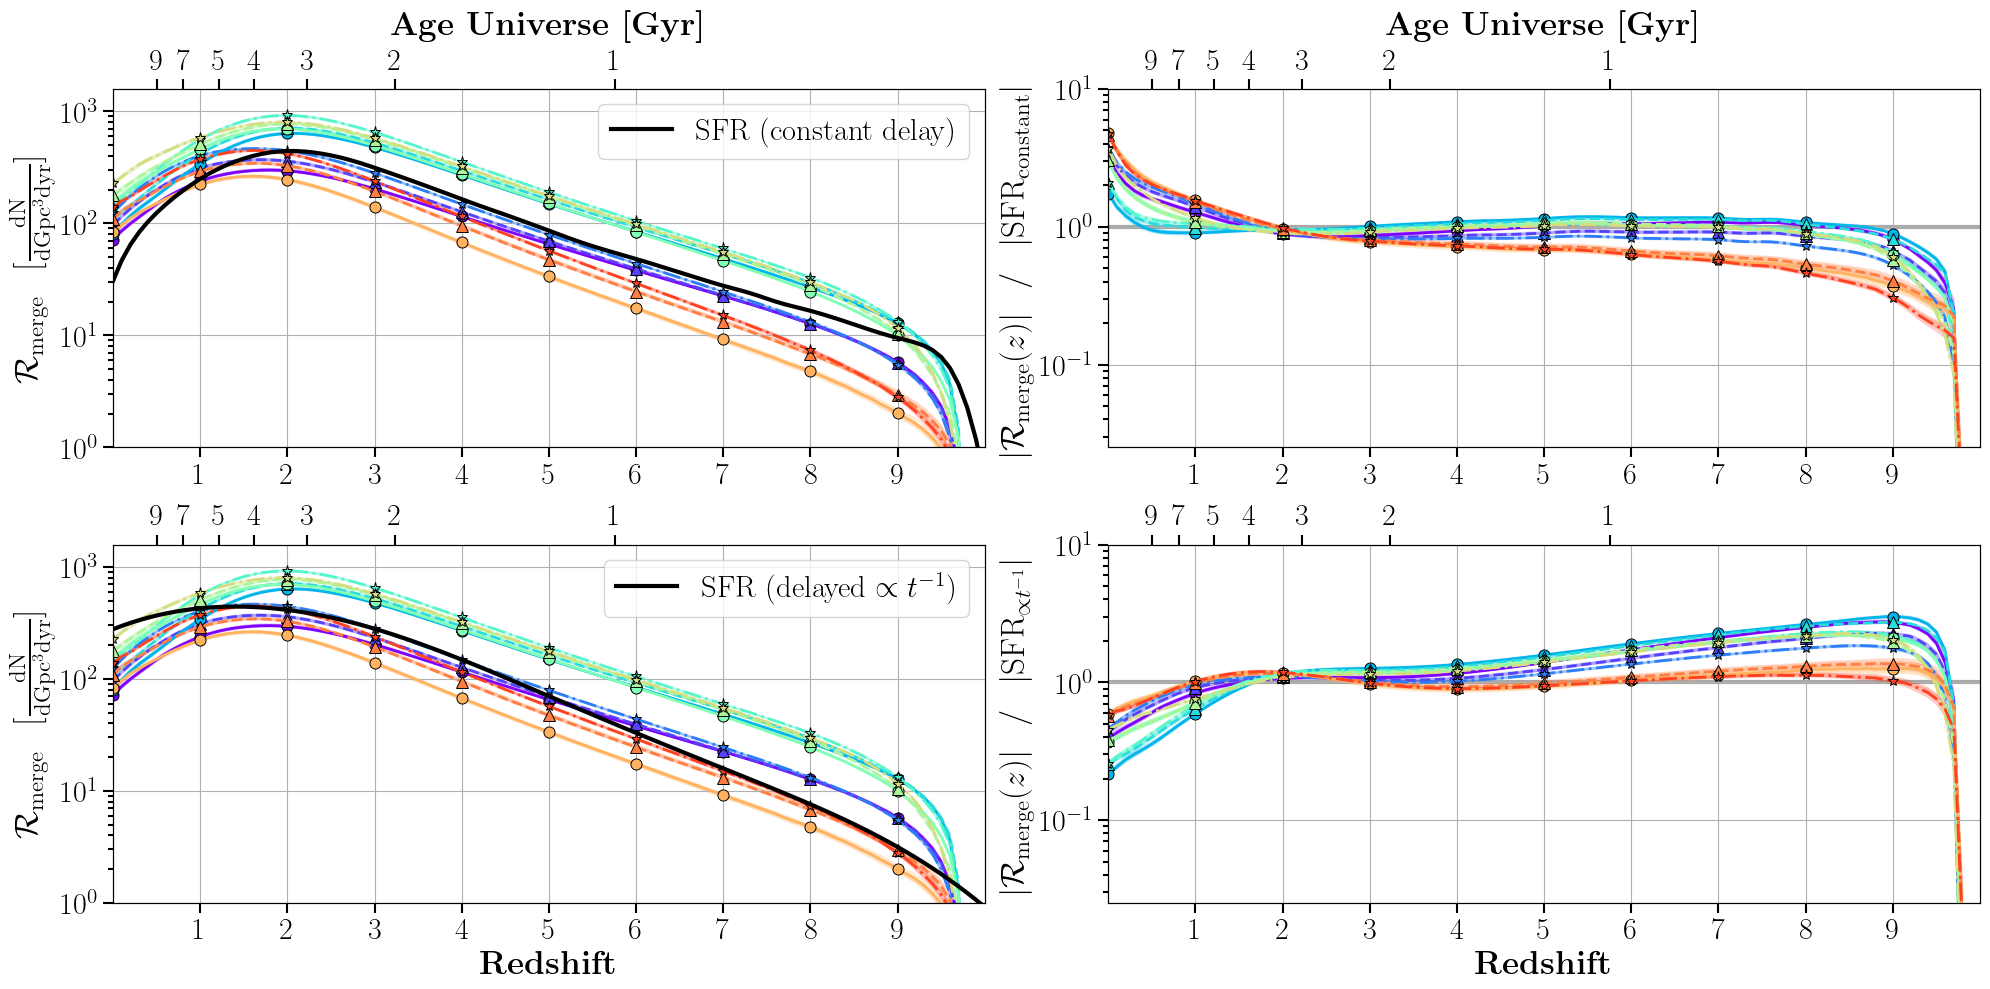

In [21]:
plot_delayed_rates_sfr_norm(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', sfr_redshifts_kde_uniform=uniform_delayed_sfrs['axis'], sfr_kde_uniform=uniform_delayed_sfrs['20'], sfr_redshifts_kde_tinv=sfr_axis, sfr_kde_tinv=tinv_delayed_sfrs['20'][1], weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step,
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(1, 10**3.2), panel2_range=(10**-1.6, 10), show_legend=False)

# Fiducial merger rate divided by SFR shifted different amounts

In [111]:
def plot_pickled_rates_delayed_sfr_norm_fiducial(condensed_paths, shifted_redshifts, alpha_val, beta_val, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, 
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None):         # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)

    with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps.h5', 'rb') as f:
        # Get data
        h5_data = h5.File(f)
        total_merger_rates= h5_data['Actual']['total_merger_rates'][...]
        # redshifts[alpha_val][beta_val] = dict['redshfits']
        redshifts = h5_data['Actual']['redshifts'][...]

        # Declare bins for the chirp mass KDE
        COMPAS = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
        COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
        COMPAS.setCOMPASData()
        COMPAS.set_sw_weights(weight_column)            

    # # Delete trash object
    # del COMPASs

    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 20
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    # Retreive the SFR
    MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
    MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
    ages = MSSFR.cosmology.age(redshifts).value         # Get the ages
    sfr = MSSFR.returnSFR(redshifts, ages)              # Get the SFR

    rate_line = axes[0].plot(redshifts, total_merger_rates, lw=lw, color='k')
    merger_rate_area = np.trapz(total_merger_rates, x=redshifts)
    for shift, shifted_z in shifted_redshifts.items():
        if len(shifted_z) == 2:
            tinv_axis = shifted_z[0]
            tinv_sfr = shifted_z[1]
            shift_mask = redshifts <= max(tinv_axis)
            sfr_interped = np.interp(redshifts[shift_mask], tinv_axis, tinv_sfr)
            until_today_mask = tinv_axis > 0.0
            shifted_z = tinv_axis[until_today_mask]
            current_sfr = tinv_sfr[until_today_mask]
            delay_label = r'$t_{\rm{min}} = $ ' + shift
        else:
            current_sfr = sfr
            shift_mask = redshifts <= max(shifted_z)
            sfr_interped = np.interp(redshifts[shift_mask], shifted_z, current_sfr)
            delay_label = f'{shift} Myr Delay'
        sfr_area = np.trapz(sfr_interped, x=redshifts[shift_mask])               # Get the area under the curve
        sfr_interped_normalized = sfr_interped/sfr_area                           # Make it so the area under the curve is 1

        # Mask for the values that are large enough to be relevant
        relevant_mask = sfr_interped_normalized > 0.005
        sfr_interped_normalized = sfr_interped_normalized[relevant_mask]

        # Plot each of the panels, and their confidence intervals
        # axes[0].plot(redshifts[alpha_val][beta_val], total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val, color=color_grid[alpha_val][beta_val])
        axes[1].plot(redshifts[shift_mask][relevant_mask], (total_merger_rates[shift_mask][relevant_mask] / merger_rate_area) / sfr_interped_normalized, lw=lw, label=delay_label)
        
        # Plot SFRs
        # Scale SFR differently for each DCO type
        current_sfr = current_sfr/max(current_sfr)
        merger_const = max(total_merger_rates[shift_mask][relevant_mask])
        axes[0].plot(shifted_z, current_sfr * merger_const, lw=3, linestyle='dashed', zorder=-1)
            
    
    # Label axes of all the plots
    axes[0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[0].set_ylabel(r'\textbf{Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$}', fontsize=fs)
    axes[0].set_yscale('log')

    axes[1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[1].set_ylabel(r'\textbf{$|\mathcal{R}_{\rm{merge}}(z)|  \ \  /  \ \  |\textrm{\textnormal{SFR}}(z)|$}', fontsize=fs)
    axes[1].set_yscale('log')

    # Set lower bounds for the plots
    if panel1_range:
        axes[0].set_ylim(panel1_range)
    if panel2_range:
        axes[1].set_ylim(panel2_range)

    for ax in axes.flatten():
            ax.tick_params(labelsize=0.9*fs)
    
    

    # Plot horizontal line for SFR on the normalized plots
    axes[1].axhline(y=1, color='darkgray', lw=3, zorder=-1)
    
    # Add lookback axes
    add_lookback_t_axes(axes[0], labelsize=fs)
    add_lookback_t_axes(axes[1], labelsize=fs)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.9*fs)

    # Include legend
    leg = fig.legend(fontsize=22, ncol=6, bbox_to_anchor=(0.9, 1.02),  markerscale=25) 
    legend2 = axes[0].legend(rate_line, [r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val], fontsize=22, loc='upper right')
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)

    axes[0].grid()
    axes[1].grid()

    axes[0].set_xlim([0, 10])
    axes[1].set_xlim([0, 10])

    # Show the plot!
    plt.show()

In [95]:
with open(path_to_data + 'output_alpha_CE_0.1_beta_0.5/Pickled_Rates/MSSFR_111/BBH/rates_and_bootstraps.h5', 'rb') as f:
    # Get data
    h5_data = h5.File(f)

    # Get redshifts to use for the SFR
    sfr_redshifts = h5_data['Actual']['redshifts'][...]

ages_yrs = cosmology.age(sfr_redshifts).to(u.Myr).value

ages_yrs_250 = ages_yrs * u.Myr + 250 * u.Myr
z_shifted_250 = z_at_value(cosmology.age, ages_yrs_250, zmin=-1)

ages_yrs_500 = ages_yrs * u.Myr + 500 * u.Myr
z_shifted_500 = z_at_value(cosmology.age, ages_yrs_500, zmin=-1)

ages_yrs_750 = ages_yrs * u.Myr + 750 * u.Myr
z_shifted_750 = z_at_value(cosmology.age, ages_yrs_750, zmin=-1)

ages_yrs_1000 = ages_yrs * u.Myr + 1000 * u.Myr
z_shifted_1000 = z_at_value(cosmology.age, ages_yrs_1000, zmin=-1)

shifted_zs = {'0': sfr_redshifts, '250': z_shifted_250, '500': z_shifted_500, '750': z_shifted_750, '1000': z_shifted_1000}

/Users/adamboesky/opt/anaconda3/envs/PRISE/lib/python3.9/site-packages/astropy/cosmology/flrw/base.py:1057: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(self._lookback_time_integrand_scalar, z, inf)[0]


ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


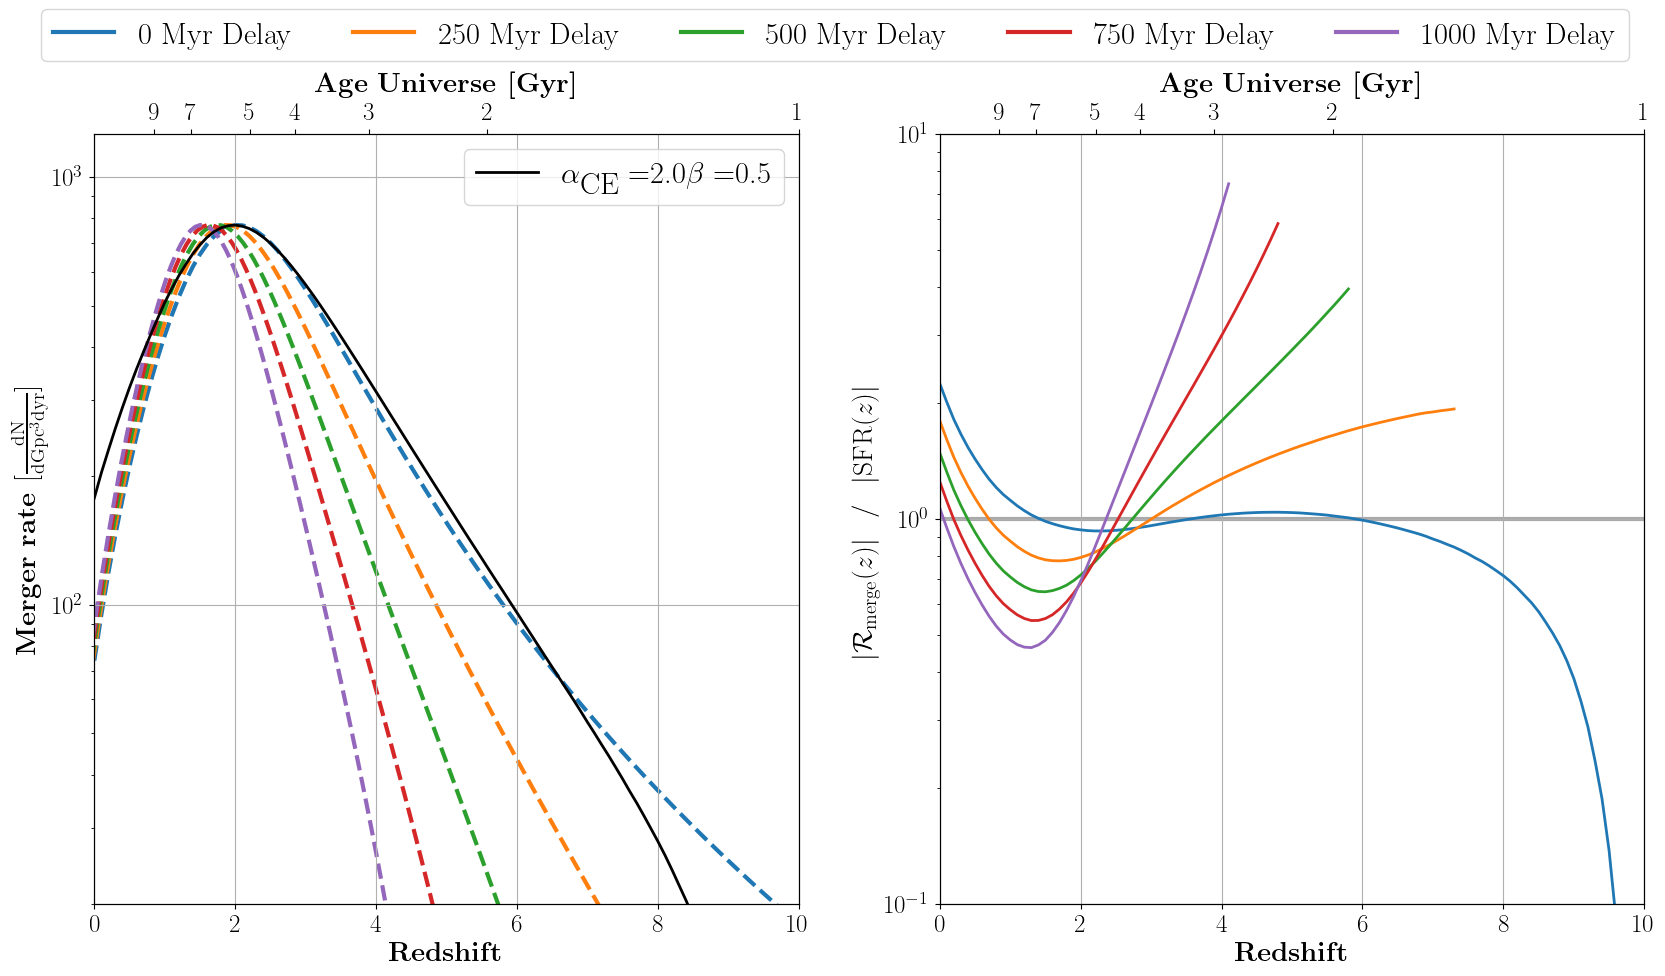

In [112]:
plot_pickled_rates_delayed_sfr_norm_fiducial(condensed_paths, shifted_zs, '2.0', '0.5', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step, 
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,
            panel1_range=(10**1.3, 10**3.1), panel2_range=(10**-1, 10))                               

In [50]:
sample_size = len(sfr_sample)
min_t_delays = ['5', '10', '20', '50', '100', '500']  # Min delay times [Myr]
tinv_delayed_sfrs = {}
sfr_axis = np.arange(-1, 10.1, 0.01)

for min_delay in min_t_delays:
    sample_delays = draw_t_inv(float(min_delay), t_delay_max, 'myr', size=sample_size)
    sample_yrs = cosmology.age(sfr_sample).to(u.Myr).value
    ages_t_inv = sample_yrs * u.Myr + sample_delays * u.Myr
    delayed_sfr = z_at_value(cosmology.age, ages_t_inv, zmin=-1)
    delayed_sfr_kde = FFTKDE().fit(delayed_sfr).evaluate(sfr_axis)
    tinv_delayed_sfrs[min_delay] = (sfr_axis, delayed_sfr_kde)

/Users/adamboesky/opt/anaconda3/envs/PRISE/lib/python3.9/site-packages/astropy/cosmology/flrw/base.py:1057: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(self._lookback_time_integrand_scalar, z, inf)[0]
/Users/adamboesky/opt/anaconda3/envs/PRISE/lib/python3.9/site-packages/astropy/cosmology/flrw/base.py:1057: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(self._lookback_time_integrand_scalar, z, inf)[0]
/Users/adamboesky/opt/anaconda3/envs/PRISE/lib/python3.9/site-packages/astropy/cosmology/flrw/base.py:1057: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(self._lookback_time_integrand_scalar, z, inf)[0]
/Users/adamboesky/opt/anaconda3/envs/PRISE/lib/python3.9/site-packages/astropy/cosmology/flrw/base.py:1057: IntegrationWarning: Extremely bad integrand behavior occurs a

In [53]:
sample_delays = draw_t_inv(500.0, t_delay_max, 'myr', size=sample_size)
sample_yrs = cosmology.age(sfr_sample).to(u.Myr).value
ages_t_inv = sample_yrs * u.Myr + sample_delays * u.Myr
delayed_sfr = z_at_value(cosmology.age, ages_t_inv, zmin=-1)
delayed_sfr_kde = FFTKDE().fit(delayed_sfr).evaluate(sfr_axis)
tinv_delayed_sfrs[min_delay] = (sfr_axis, delayed_sfr_kde)

/Users/adamboesky/opt/anaconda3/envs/PRISE/lib/python3.9/site-packages/astropy/cosmology/flrw/base.py:1057: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(self._lookback_time_integrand_scalar, z, inf)[0]


In [68]:
with open("t_inv_delayed_sft.pkl", "wb") as f:
    pickle.dump(tinv_delayed_sfrs, f)

In [18]:
with open('t_inv_delayed_sft.pkl', 'rb') as f:
    tinv_delayed_sfrs = pickle.load(f)
sfr_axis = np.arange(-1, 10.1, 0.01)

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


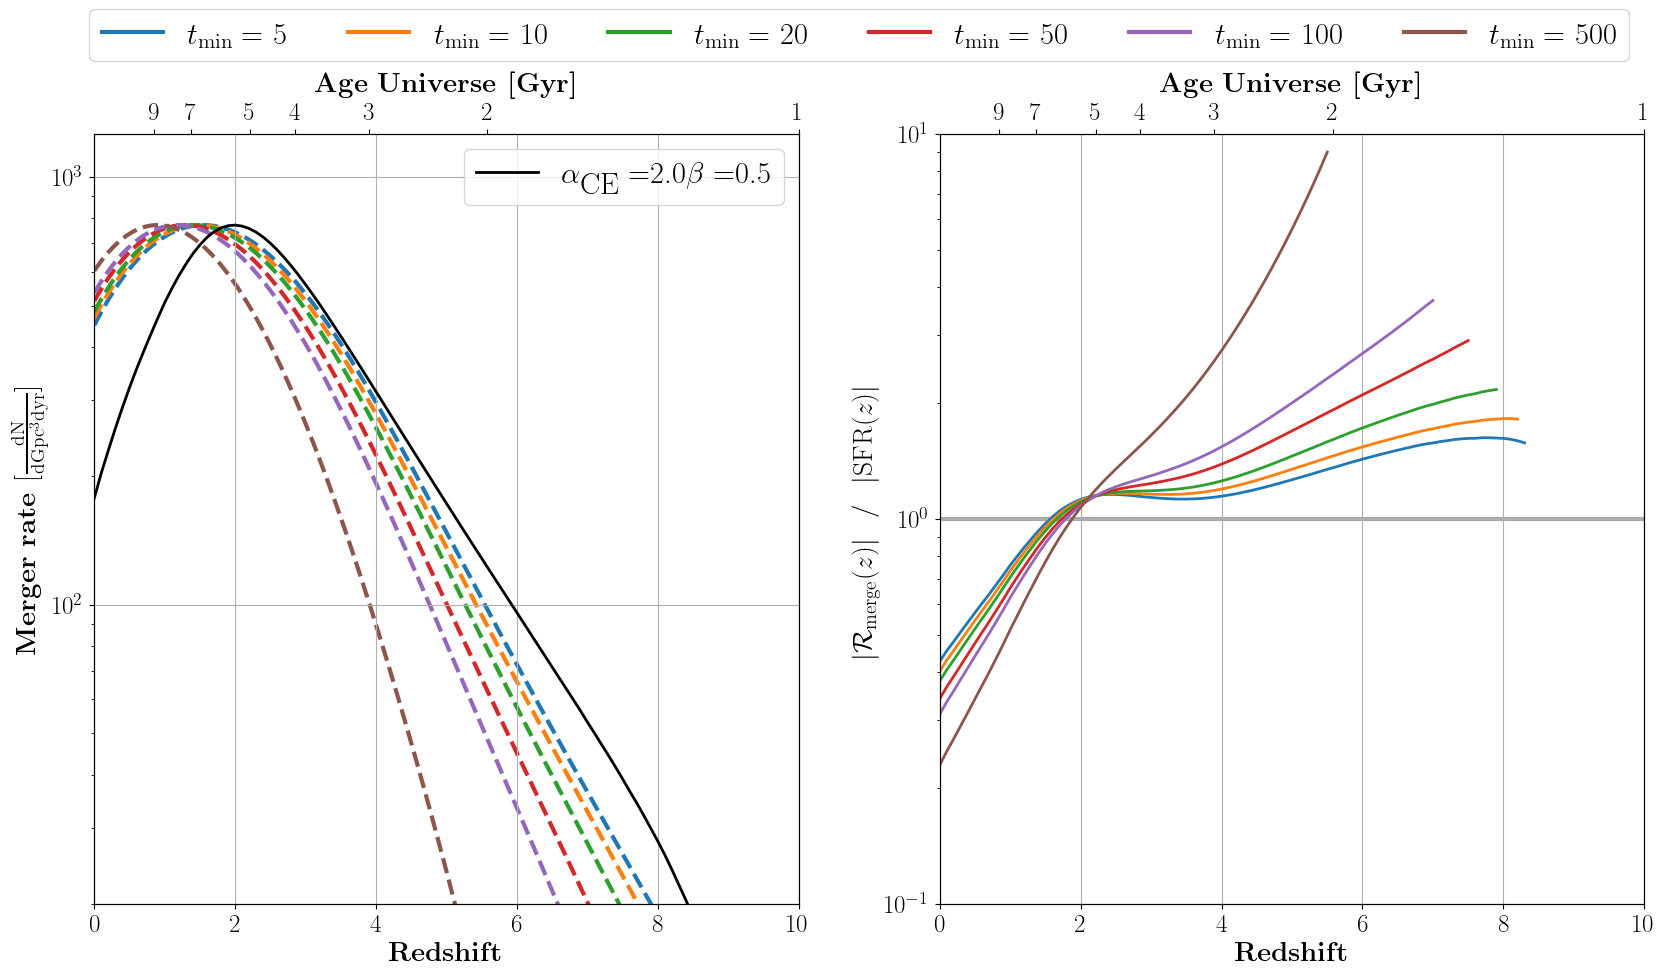

In [113]:
plot_pickled_rates_delayed_sfr_norm_fiducial(condensed_paths, tinv_delayed_sfrs, '2.0', '0.5', dco_type='BBH', weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step,
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,
            panel1_range=(10**1.3, 10**3.1), panel2_range=(10**-1, 10))

# Rates scaled by $\mathcal{R}_0$

In [22]:
def plot_rates_sfr_norm_R0(condensed_paths, alpha_vals, beta_vals, sfr_redshifts_kde_uniform, sfr_kde_uniform, sfr_redshifts_kde_tinv, sfr_kde_tinv, dco_type=None, merger_output_filename=None, weight_column=None,
    merges_hubble_time=True, pessimistic_CEE=True, no_RLOF_after_CEE=True,
    max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10,
    use_sampled_mass_ranges=True, m1_min=5 * u.Msun, m1_max=150 * u.Msun, m2_min=0.1 * u.Msun, fbin=1.0,
    aSF = 0.01, bSF = 2.77, cSF = 2.90, dSF = 4.70,
    mu0=0.035, muz=-0.23, sigma0=0.39,sigmaz=0., alpha=0.0, 
    min_logZ=-12.0, max_logZ=1.0, step_logZ=0.01,
    sensitivity="O1", snr_threshold=8, 
    Mc_max=300.0, Mc_step=0.1, eta_max=0.25, eta_step=0.01,
    snr_max=1000.0, snr_step=0.1, lw=2, show_legend=True, legend_2_label='SFR',
    lognormal=False, Zprescription='MZ_GSMF', SFRprescription='Madau et al. (2017)',        # ADAM'S FIDUCIAL MSSFR PARAMETERS
    GSMFprescription='Panter et al. (2004) Single', ZMprescription='Ma et al. (2016)',      # ADAM'S FIDUCIAL MSSFR PARAMETERS
    logNormalPrescription=None, n_iters=100, panel1_range=None, panel2_range=None,          # ADAM'S FIDUCIAL MSSFR PARAMETERS
    panel3_range=None):                                                                     # ADAM'S FIDUCIAL MSSFR PARAMETERS
    
    # Make sure the dco_type is given
    assert dco_type != None, 'dco_type must be given'

    CI_kwargs = {'dco_type': dco_type, 'merger_output_filename': merger_output_filename, 'weight_column': weight_column, 'merges_hubble_time': merges_hubble_time, 'pessimistic_CEE': pessimistic_CEE, 
                        'no_RLOF_after_CEE': no_RLOF_after_CEE, 'max_redshift': max_redshift, 'max_redshift_detection': max_redshift_detection, 'redshift_step': redshift_step, 'z_first_SF': z_first_SF,
                        'use_sampled_mass_ranges': use_sampled_mass_ranges, 'm1_min': m1_min, 'm1_max': m1_max, 'm2_min': m2_min, 'fbin': fbin,
                        'aSF': aSF, 'bSF': bSF, 'cSF': cSF, 'dSF': dSF,
                        'mu0': mu0, 'muz': muz, 'sigma0': sigma0, 'sigmaz': sigmaz, 'alpha': alpha, 
                        'min_logZ': min_logZ, 'max_logZ': max_logZ, 'step_logZ': step_logZ,
                        'sensitivity': sensitivity, 'snr_threshold': snr_threshold, 
                        'Mc_max': Mc_max, 'Mc_step': Mc_step, 'eta_max': eta_max, 'eta_step': eta_step,
                        'snr_max': snr_max, 'snr_step': snr_step,
                        'lognormal': lognormal, 'Zprescription': Zprescription, 'SFRprescription': SFRprescription,
                        'GSMFprescription': GSMFprescription, 'ZMprescription': ZMprescription,
                        'logNormalPrescription': logNormalPrescription}

    # 2-D dictionaries for the data to be put in (axes correspond to alpha and beta values)
    total_merger_rates = {}
    total_detection_rates = {}
    cumulative_detection_rates = {}
    detection_rates_by_binary = {}
    mass_kde_scaled = {}
    redshifts = {}
    Mc_bins = {}
    one_sigma = {}
    two_sigma = {}

    for alpha_index, alpha_val in enumerate(alpha_vals):
        # Make the dictionary "2D"
        total_merger_rates[alpha_val] = {}
        total_detection_rates[alpha_val] = {}
        cumulative_detection_rates[alpha_val] = {}
        detection_rates_by_binary[alpha_val] = {}
        mass_kde_scaled[alpha_val] = {}
        Mc_bins[alpha_val] = {}
        one_sigma[alpha_val] = {}
        two_sigma[alpha_val] = {}

        redshifts[alpha_val] = {}

        for beta_index, beta_val in enumerate(beta_vals):
            one_sigma[alpha_val][beta_val] = {}
            two_sigma[alpha_val][beta_val] = {}
        
            with open(path_to_data + 'output_alpha_CE_' + alpha_val + '_beta_' + beta_val + '/Pickled_Rates/MSSFR_111/' + dco_type + '/rates_and_bootstraps.h5', 'rb') as f:
                # Get data
                h5_data = h5.File(f)
                total_merger_rates[alpha_val][beta_val] = h5_data['Actual']['total_merger_rates'][...]
                # redshifts[alpha_val][beta_val] = dict['redshfits']
                redshifts[alpha_val][beta_val] = h5_data['Actual']['redshifts'][...]
                cumulative_detection_rates[alpha_val][beta_val] = h5_data['Actual']['cumulative_detection_rates'][...]
                mass_kde_scaled[alpha_val][beta_val] = h5_data['Actual']['mass_kde_scaled'][...]

                # Declare bins for the chirp mass KDE
                COMPAS = ClassCOMPAS.COMPASData(condensed_paths[alpha_val][beta_val], Mlower=m1_min, Mupper=m1_max, m2_min=m2_min, binaryFraction=fbin, suppress_reminder=True)
                COMPAS.setCOMPASDCOmask(types=dco_type, withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE)
                COMPAS.setCOMPASData()
                COMPAS.set_sw_weights(weight_column)            
                chirp_masses = (COMPAS.mass1*COMPAS.mass2)**(3./5.) / (COMPAS.mass1 + COMPAS.mass2)**(1./5.)
                Mc_bins[alpha_val][beta_val] = np.arange(0, max(chirp_masses)*1.3, max(chirp_masses)*1.2/100) # We need to pass in the bins for the chirp mass distribution so we will declare them here

                # empty trash
                del chirp_masses
                del COMPAS

                # Calculate confidence intervals
                one_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [16, 84], axis=0)
                one_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [16, 84], axis=0)

                # Get the two sigma confidence intervals
                two_sigma[alpha_val][beta_val]['total_merger_rates']             =   np.percentile(h5_data['Bootstraps']['total_merger_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['cumulative_detection_rates']     =   np.percentile(h5_data['Bootstraps']['cumulative_detection_rates'][...], [2.5, 97.5], axis=0)
                two_sigma[alpha_val][beta_val]['mass_kde']                       =   np.percentile(h5_data['Bootstraps']['mass_kde'][...], [2.5, 97.5], axis=0)

            # # Delete trash object
            # del COMPASs



    ###########################
    #Start plotting

    # set some constants for the plots
    plt.rc('font', family='serif')
    fs = 24
    tickLengthMajor = 7
    tickLengthMinor = 3.5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    # Get redshifts to use for the SFR
    sfr_redshifts = redshifts['0.1']['0.5']

    # Retreive the SFRs
    MSSFR = ClassMSSFR.MSSFR()                              # Create an MSSFR object
    MSSFR.SFRprescription = SFRprescription                 # Set SFR prescription
    ages = MSSFR.cosmology.age(sfr_redshifts).value         # Get the ages

    sfr = MSSFR.returnSFR(sfr_redshifts, ages)
    sfr_uniform = np.interp(sfr_redshifts, sfr_redshifts_kde_uniform, sfr_kde_uniform)
    sfr_tinv = np.interp(sfr_redshifts, sfr_redshifts_kde_tinv, sfr_kde_tinv)

    if dco_type == 'BBH':
        marker_period = 10
    else:
        marker_period = 1000

    for alpha_val in alpha_vals:
        for beta_val in beta_vals:
            merger_rate_area = np.trapz(total_merger_rates[alpha_val][beta_val], x=redshifts[alpha_val][beta_val])
            normalized_merger_rate = (total_merger_rates[alpha_val][beta_val] / merger_rate_area)
            R0 = normalized_merger_rate[0]

            # Plot each of the panels, and their confidence intervals
            axes[0].plot(redshifts[alpha_val][beta_val], normalized_merger_rate / (sfr * R0 / sfr[0]), lw=lw, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[0].fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_merger_rates'][0] / (merger_rate_area * sfr * R0 / sfr[0]), y2=one_sigma[alpha_val][beta_val]['total_merger_rates'][1] / (merger_rate_area * sfr * R0 / sfr[0]), alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[0].fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_merger_rates'][0] / (merger_rate_area * sfr * R0 / sfr[0]), y2=two_sigma[alpha_val][beta_val]['total_merger_rates'][1] / (merger_rate_area * sfr * R0 / sfr[0]), alpha=0.2, color=color_grid[alpha_val][beta_val])
            
            axes[1].plot(redshifts[alpha_val][beta_val], normalized_merger_rate / (sfr_uniform * R0 / sfr_uniform[0]), lw=lw, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[1].fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_merger_rates'][0] / (merger_rate_area * sfr_uniform * R0 / sfr_uniform[0]), y2=one_sigma[alpha_val][beta_val]['total_merger_rates'][1] / (merger_rate_area * sfr_uniform * R0 / sfr_uniform[0]), alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[1].fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_merger_rates'][0] / (merger_rate_area * sfr_uniform * R0 / sfr_uniform[0]), y2=two_sigma[alpha_val][beta_val]['total_merger_rates'][1] / (merger_rate_area * sfr_uniform * R0 / sfr_uniform[0]), alpha=0.2, color=color_grid[alpha_val][beta_val])
            
            axes[2].plot(redshifts[alpha_val][beta_val], normalized_merger_rate / (sfr_tinv * R0 / sfr_tinv[0]), lw=lw, color=color_grid[alpha_val][beta_val], marker=marker_grid[alpha_val][beta_val], mec='k', mfc=color_grid[alpha_val][beta_val], markersize=8, markevery=marker_period, linestyle=linestyle_grid[alpha_val][beta_val], markeredgewidth=0.7)
            axes[2].fill_between(x=redshifts[alpha_val][beta_val], y1=one_sigma[alpha_val][beta_val]['total_merger_rates'][0] / (merger_rate_area * sfr_tinv * R0 / sfr_tinv[0]), y2=one_sigma[alpha_val][beta_val]['total_merger_rates'][1] / (merger_rate_area * sfr_tinv * R0 / sfr_tinv[0]), alpha=0.2, color=color_grid[alpha_val][beta_val])
            axes[2].fill_between(x=redshifts[alpha_val][beta_val], y1=two_sigma[alpha_val][beta_val]['total_merger_rates'][0] / (merger_rate_area * sfr_tinv * R0 / sfr_tinv[0]), y2=two_sigma[alpha_val][beta_val]['total_merger_rates'][1] / (merger_rate_area * sfr_tinv * R0 / sfr_tinv[0]), alpha=0.2, color=color_grid[alpha_val][beta_val])
    
    # Label axes of all the plots
    axes[0].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[0].set_ylabel(r'\textbf{$\mathcal{R}_{\rm{merge}}(z)  \ \  /  \ \  (R_{\rm{merge}}(0) \ \textrm{\textnormal{SFR}}(z))$}', fontsize=fs)
    axes[0].set_yscale('log')

    axes[1].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[1].set_ylabel(r'\textbf{$\mathcal{R}_{\rm{merge}}(z)  \ \  /  \ \  (R_{\rm{merge}}(0) \ \textrm{\textnormal{SFR}}_{\rm{constant}}(z))$}', fontsize=fs)
    axes[1].set_yscale('log')

    axes[2].set_xlabel(r'\textbf{Redshift}', fontsize=fs)
    axes[2].set_ylabel(r'\textbf{$\mathcal{R}_{\rm{merge}}(z)  \ \  /  \ \  (R_{\rm{merge}}(0) \ \textrm{\textnormal{SFR}}_{\propto t^{-1}}(z))$}', fontsize=fs)
    axes[2].set_yscale('log')

    # Set lower bounds for the plots
    if panel1_range:
        axes[0].set_ylim(panel1_range)
    if panel2_range:
        axes[1].set_ylim(panel2_range)
    if panel2_range:
        axes[2].set_ylim(panel3_range)

    for ax in axes.flatten():
            ax.tick_params(labelsize=fs*0.9)

    # Plot horizontal line for SFR on the normalized plots and do some formatting
    redshift_ticks = np.arange(1, 10, 1)
    for ax in axes.flatten():
        ax.tick_params(labelsize=fs*0.9)
        ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
        ax.axhline(y=1, color='darkgray', lw=3, zorder=-1)
        ax.xaxis.set_ticks(redshift_ticks)
        ax.set_xlim((0,10))
        ax.grid()

    # Include legend
    if show_legend:
        leg = fig.legend(fontsize=22, ncol=4, bbox_to_anchor=(0.875, 1.25),  markerscale=1) 
        for legobj in leg.legendHandles:
            legobj.set_linewidth(3.0)

    # Add lookback time axis
    ax_top1 = add_lookback_t_axes(axes[0], labelsize=fs)
    ax_top2 = add_lookback_t_axes(axes[1], labelsize=fs)
    ax_top3 = add_lookback_t_axes(axes[2], labelsize=fs)
    for ax_top in (ax_top1, ax_top2, ax_top3):
        ax_top.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
        ax_top.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')

    # Show the plot!
    plt.tight_layout()
    plt.show()

ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()


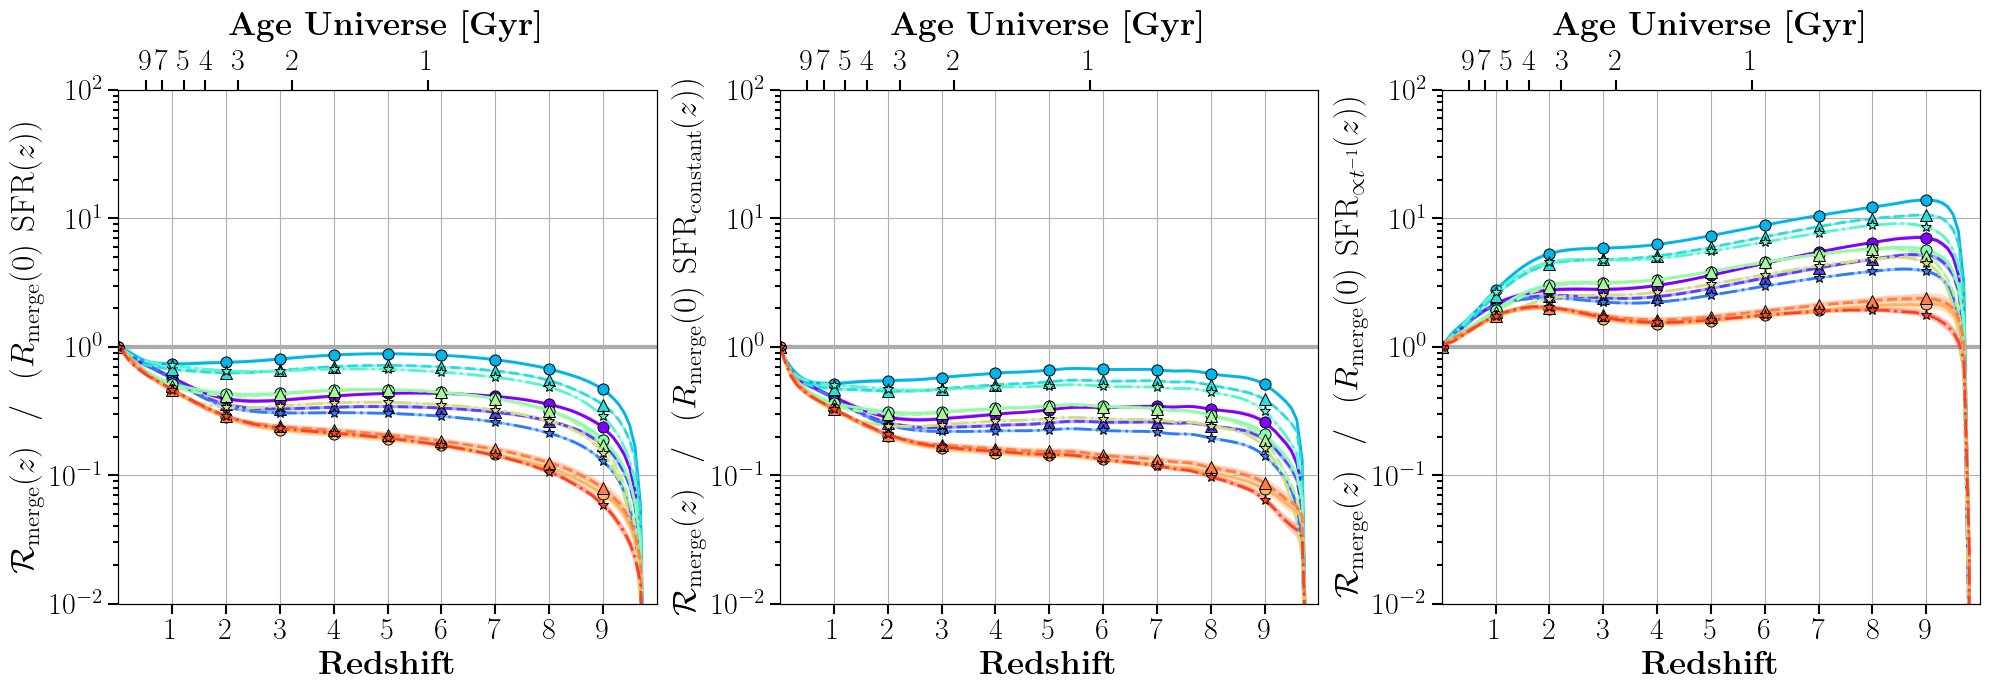

In [23]:
plot_rates_sfr_norm_R0(condensed_paths, alpha_vals, beta_vals, dco_type='BBH', sfr_redshifts_kde_uniform=uniform_delayed_sfrs['axis'], sfr_kde_uniform=uniform_delayed_sfrs['20'], sfr_redshifts_kde_tinv=sfr_axis, sfr_kde_tinv=tinv_delayed_sfrs['20'][1], weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step,
            lognormal=lognormal, Zprescription=Zprescription, SFRprescription=SFRprescription,      # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            GSMFprescription=GSMFprescription, ZMprescription=ZMprescription,                       # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            logNormalPrescription=logNormalPrescription, n_iters=100,                               # ADAM'S NON-LOGNORMAL MSSFR PRESCRIPTIONS
            panel1_range=(10**-2, 10**2), panel2_range=(10**-2, 10**2), panel3_range=(10**-2, 10**2), show_legend=False)